# NanoMAD ML - Comprehensive Demo

## What is this project?

This project develops a **CNN-based replacement** for the traditional NanoMAD fitting approach used in **Multi-wavelength Anomalous Diffraction (MAD)** analysis of **Bragg Coherent Diffraction Imaging (BCDI)** data.

### The Problem We're Solving

In BCDI experiments on **core-shell nanoparticles** (e.g., Fe core with Ni shell), we collect diffraction patterns at multiple X-ray energies around an absorption edge (like the Ni K-edge at 8333 eV). The traditional NanoMAD approach fits the MAD equation at each pixel independently using expensive iterative optimization (grid search + least squares).

**Our ML approach** trains a CNN to directly predict the MAD parameters in a single forward pass, which is:
- Much faster (milliseconds vs minutes)
- Can leverage spatial correlations between neighboring pixels
- Produces smoother, more physically consistent results

### The MAD Equation

The intensity at each Q-point and energy E is given by:

$$I(Q,E) = |F_T|^2 + (f'^2 + f''^2)\frac{|F_A|^2}{f_0^2} + 2\frac{|F_T||F_A|}{f_0}[f'\cos(\Delta\phi) + f''\sin(\Delta\phi)]$$

Where:
- **$F_T$** = Total structure factor (scattering from ALL atoms: Fe + Ni)
- **$F_A$** = Anomalous structure factor (scattering from ONLY the anomalous atoms: Ni)
- **$\Delta\phi = \phi_T - \phi_A$** = Phase difference between F_T and F_A
- **$f_0(Q)$** = Thomson scattering factor (Q-dependent, energy-independent)
- **$f'(E), f''(E)$** = Anomalous corrections (energy-dependent, vary strongly near absorption edges)

### What the CNN Learns

- **Input**: 16×16×8 intensity patches (Q-space at 8 energies) + f'/f'' scattering factors
- **Output**: 16×16×4 physical parameters: |F_T|, |F_A|, sin(Δφ), cos(Δφ)

From these outputs, we can derive **$F_N$** (the non-anomalous structure factor), which **isolates the Fe core contribution** from the Ni shell!

---

## This Notebook

This notebook demonstrates:

1. **All Particle Types** - Circle, hexagon, polygon, centrosymmetric polygon
2. **Strain Field Layers** - Each component visualized separately
3. **Multi-Energy Diffraction** - How patterns change with energy
4. **Ground Truth Label Calculation** - How we compute the training targets
5. **F_N Derivation** - How to isolate core vs shell contributions

---

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# Add parent directory to path for imports
sys.path.insert(0, str(Path('.').resolve().parent))

# Set up plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

# Random seed for reproducibility
np.random.seed(42)

print("Imports complete!")

Imports complete!


In [2]:
# Import our physics modules
from src.core_shell import (
    create_particle_with_shape,
    apply_displacement_to_particle,
    create_layered_displacement_field,
    create_random_strain_field,
    compute_diffraction_oversampled_cropped,
    compute_ground_truth_labels,
    extract_label_patches,
    ScatteringFactors,
    get_total_density,
    SPECIES_NI,
    SPECIES_FE,
)

print("Core-shell physics module loaded!")

Core-shell physics module loaded!


In [3]:
# =============================================================================
# GLOBAL CONFIGURATION
# =============================================================================
# These parameters define our simulation setup

GRID_SIZE = 256          # FFT grid size (pixels) - larger = better sampling
GRID_SIZE_OUTPUT = 128   # Output size after cropping center of diffraction pattern
PATCH_SIZE = 16          # Patch size for CNN input (16x16 pixels)
PIXEL_SIZE = 5.0         # Real-space pixel size in Angstroms (5 Å = 0.5 nm)
Q_BRAGG = 3.09           # Bragg peak position in Å⁻¹ (Ni 111 reflection)

# Energies around Ni K-edge (8333 eV)
# We sample 8 energies to capture the f'/f'' variation
ENERGIES = [8313, 8318, 8323, 8328, 8333, 8338, 8343, 8348]

print("=" * 70)
print("SIMULATION CONFIGURATION")
print("=" * 70)
print(f"Grid size: {GRID_SIZE}×{GRID_SIZE} pixels")
print(f"Output size: {GRID_SIZE_OUTPUT}×{GRID_SIZE_OUTPUT} pixels (after center crop)")
print(f"Patch size: {PATCH_SIZE}×{PATCH_SIZE} pixels (CNN input)")
print(f"Pixel size: {PIXEL_SIZE} Å = {PIXEL_SIZE/10:.1f} nm")
print(f"Real-space extent: {GRID_SIZE * PIXEL_SIZE / 10:.1f} nm")
print(f"Q_Bragg: {Q_BRAGG} Å⁻¹ (Ni 111 reflection)")
print(f"")
print(f"Energy points: {len(ENERGIES)}")
print(f"  Range: {min(ENERGIES)} - {max(ENERGIES)} eV")
print(f"  Ni K-edge: 8333 eV (center of range)")
print("=" * 70)

SIMULATION CONFIGURATION
Grid size: 256×256 pixels
Output size: 128×128 pixels (after center crop)
Patch size: 16×16 pixels (CNN input)
Pixel size: 5.0 Å = 0.5 nm
Real-space extent: 128.0 nm
Q_Bragg: 3.09 Å⁻¹ (Ni 111 reflection)

Energy points: 8
  Range: 8313 - 8348 eV
  Ni K-edge: 8333 eV (center of range)


<cell_type>markdown</cell_type>---

# Part 1: Particle Types

Real nanoparticles have **faceted shapes** determined by crystallography and surface energy minimization. We support several shape types to generate realistic synthetic training data:

| Shape Type | Description | Use Case |
|------------|-------------|----------|
| `circle` | Perfect circular cross-section | Spherical particles, baseline |
| `hexagon` | 6-sided polygon | Common for FCC metals (111 facets) |
| `polygon` | Random N-sided polygon | General faceted shapes |
| `polygon_centrosymmetric` | Centrosymmetric random polygon | More realistic for crystals |

Each particle has:
- **Core**: Fe-rich region (Ni₃Fe composition = 75% Ni, 25% Fe)
- **Shell**: Pure Ni region (100% Ni, 0% Fe)

This Fe/Ni distribution is what MAD analysis aims to recover!

In [4]:
# =============================================================================
# CREATE ALL PARTICLE TYPES
# =============================================================================

particle_types = ['circle', 'hexagon', 'polygon', 'polygon_centrosymmetric']
particles = {}
particle_infos = {}

print("Creating particles of each type...\n")

for shape_type in particle_types:
    print(f"{'='*70}")
    print(f"Creating: {shape_type.upper()}")
    print(f"{'='*70}")
    
    # Shape-specific parameters
    if shape_type == 'hexagon':
        shape_params = {'anisotropy': 1.15}  # Slight elongation
    elif shape_type == 'polygon':
        shape_params = {'n_vertices': 7}    # Heptagon
    elif shape_type == 'polygon_centrosymmetric':
        shape_params = {'n_vertices': 8}    # Octagon-like
    else:
        shape_params = {}
    
    particle, info = create_particle_with_shape(
        grid_size=GRID_SIZE,
        shape_type=shape_type,
        outer_radius=40,       # 40 pixels = 200 Å = 20 nm radius
        core_fraction=0.5,     # Core is 50% of particle area
        pixel_size=PIXEL_SIZE,
        shape_params=shape_params,
        verbose=True
    )
    
    particles[shape_type] = particle
    particle_infos[shape_type] = info
    print()

Creating particles of each type...

Creating: CIRCLE

  Creating circle particle...
    Grid size: 256 × 256
    Outer radius: 40 pixels
    Core fraction: 50.0%
    Total area: 5025 pixels
    Core area: 1257 pixels (25.0%)
    Shell area: 3768 pixels (75.0%)
    Core: Ni=75%, Fe=25%
    Shell: Ni=100.0%, Fe=0.0%

Creating: HEXAGON

  Creating hexagon particle...
    Grid size: 256 × 256
    Outer radius: 40 pixels
    Core fraction: 50.0%
  Hexagon created:
    Base radius: 0.156
    Rotation: 67.4°
    Anisotropy: 1.15
    Relative volume: 0.017
    Vertices: 6
    Total area: 1126 pixels
    Core area: 278 pixels (24.7%)
    Shell area: 848 pixels (75.3%)
    Core: Ni=75%, Fe=25%
    Shell: Ni=100.0%, Fe=0.0%

Creating: POLYGON

  Creating polygon particle...
    Grid size: 256 × 256
    Outer radius: 40 pixels
    Core fraction: 50.0%
  Non-centrosymmetric polygon created:
    Vertices: 7
    Relative volume: 0.063
    Aspect ratio: 1.00
    Attempts: 1
    Total area: 4134 pixels

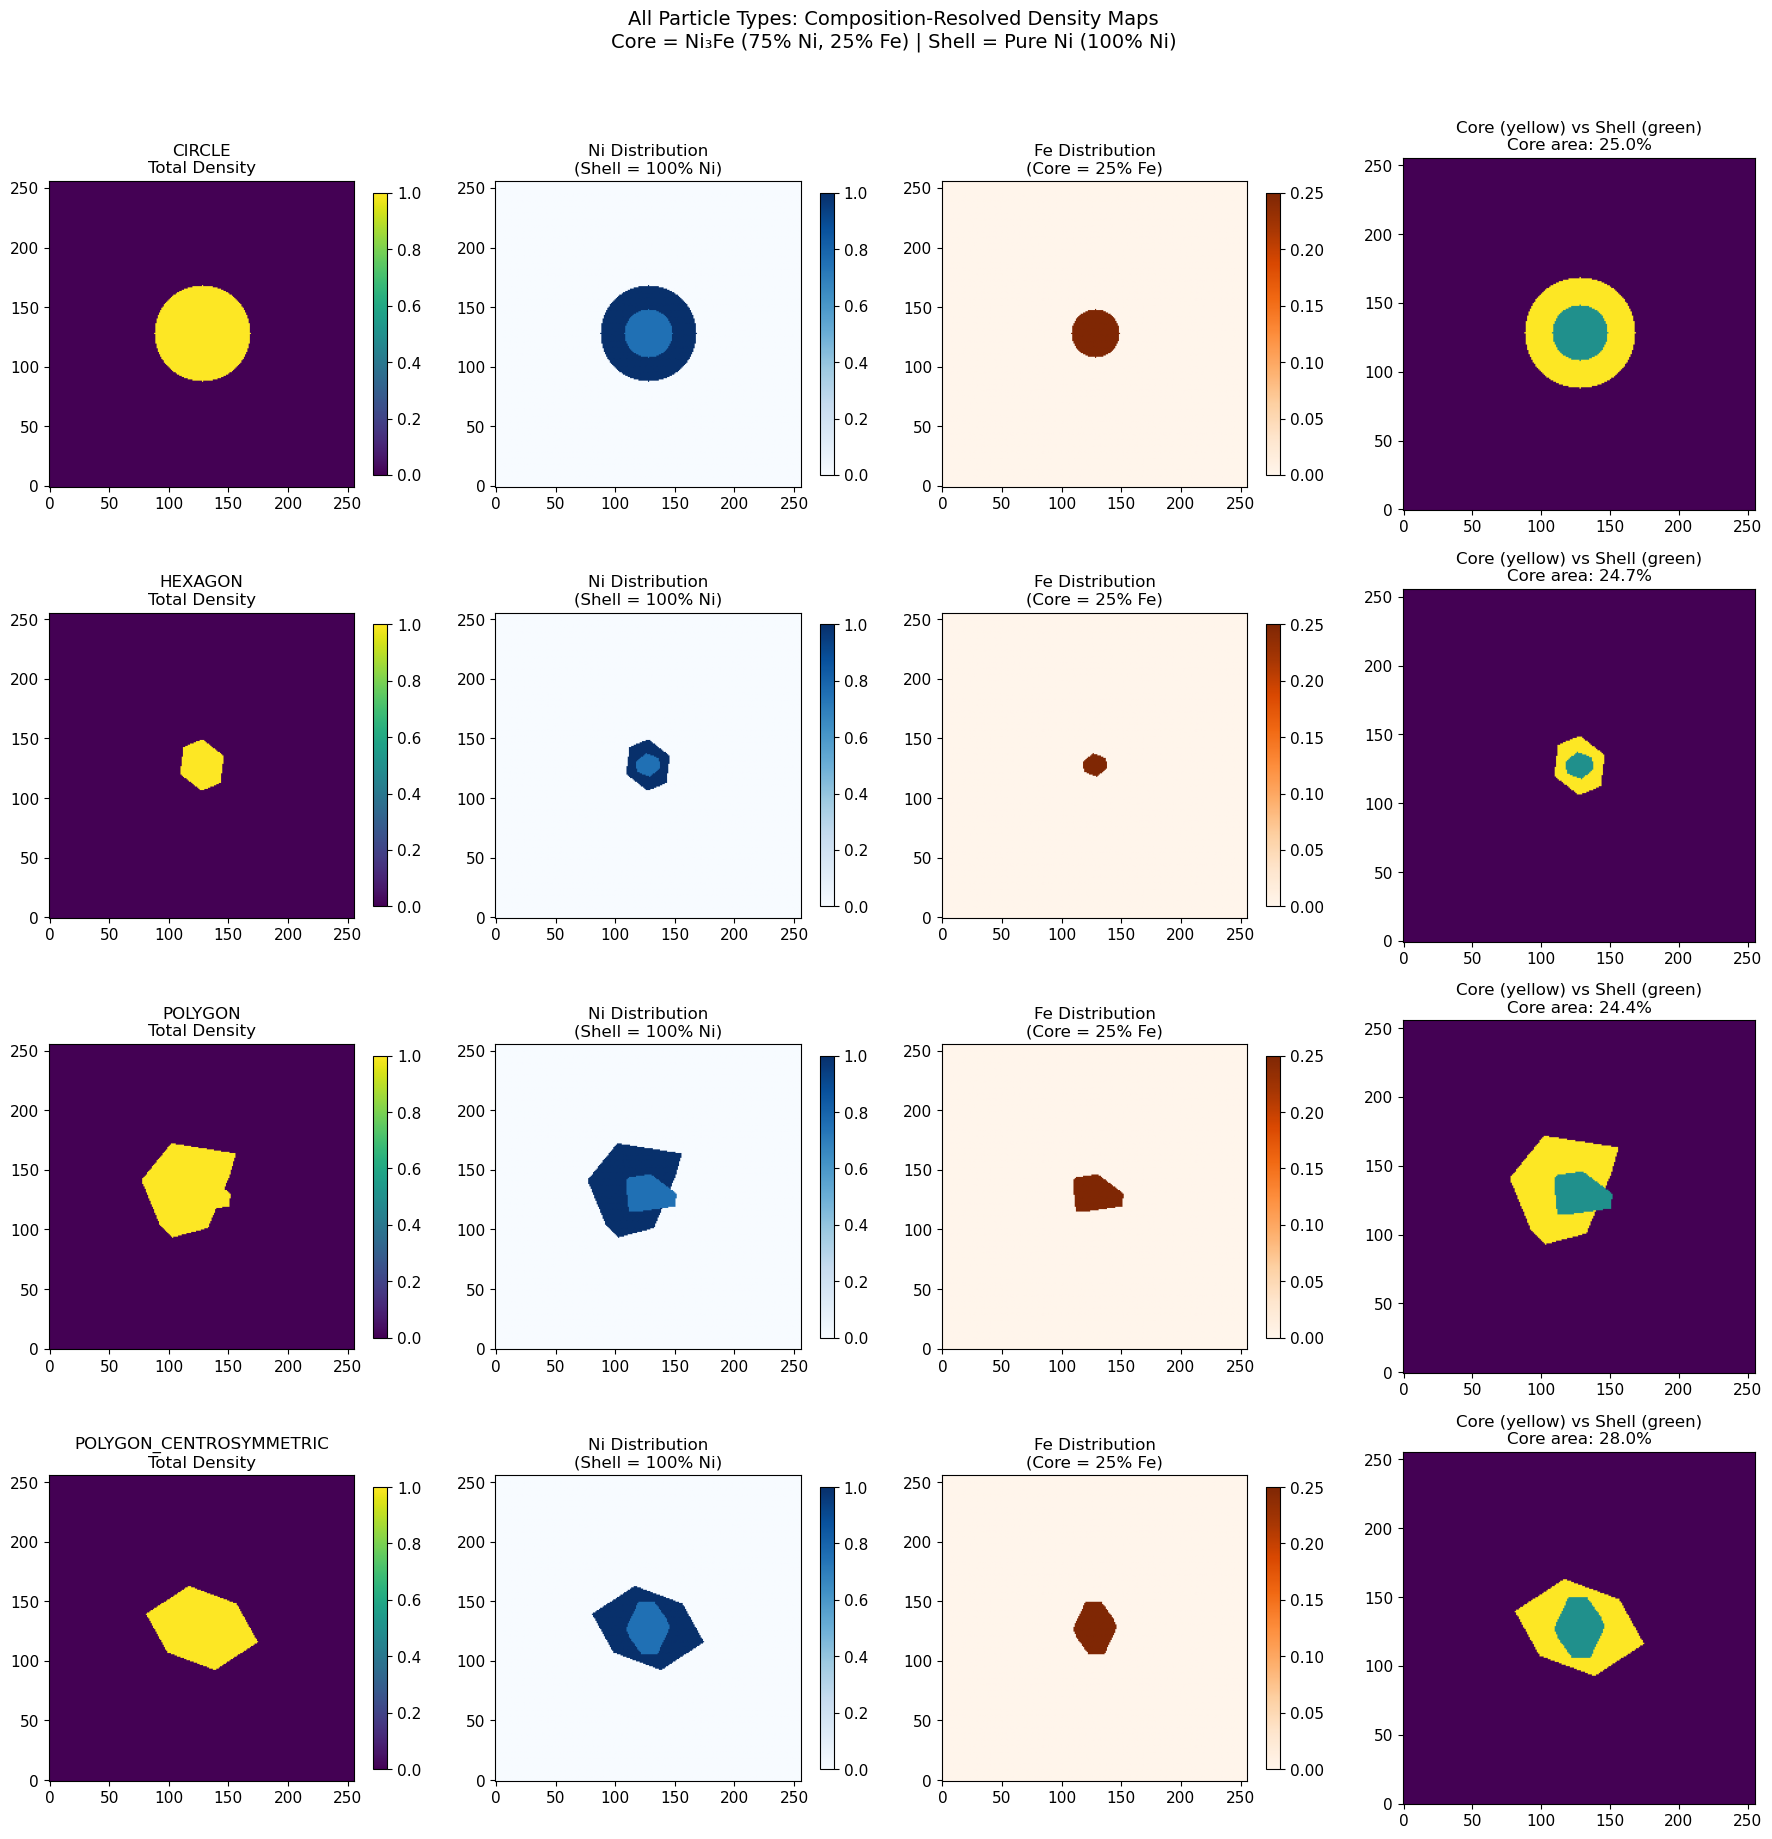


PARTICLE SUMMARY
circle                   :  5025 pixels, core=25.0%, shell=75.0%
hexagon                  :  1126 pixels, core=24.7%, shell=75.3%
polygon                  :  4134 pixels, core=24.4%, shell=78.3%
polygon_centrosymmetric  :  4064 pixels, core=28.0%, shell=72.0%


In [5]:
# =============================================================================
# VISUALIZE ALL PARTICLE TYPES
# =============================================================================

fig, axes = plt.subplots(4, 4, figsize=(18, 18))

for row, shape_type in enumerate(particle_types):
    particle = particles[shape_type]
    info = particle_infos[shape_type]
    
    # Column 0: Total density
    density = get_total_density(particle)
    im = axes[row, 0].imshow(density, cmap='viridis', origin='lower')
    axes[row, 0].set_title(f'{shape_type.upper()}\nTotal Density', fontsize=12)
    plt.colorbar(im, ax=axes[row, 0], shrink=0.8)
    
    # Column 1: Ni distribution (shell)
    im = axes[row, 1].imshow(particle[SPECIES_NI], cmap='Blues', origin='lower')
    axes[row, 1].set_title(f'Ni Distribution\n(Shell = 100% Ni)', fontsize=12)
    plt.colorbar(im, ax=axes[row, 1], shrink=0.8)
    
    # Column 2: Fe distribution (core)
    im = axes[row, 2].imshow(particle[SPECIES_FE], cmap='Oranges', origin='lower')
    axes[row, 2].set_title(f'Fe Distribution\n(Core = 25% Fe)', fontsize=12)
    plt.colorbar(im, ax=axes[row, 2], shrink=0.8)
    
    # Column 3: Core vs Shell masks
    combined = np.zeros_like(density)
    combined[info['core_mask']] = 1  # Core = blue
    combined[info['shell_mask']] = 2  # Shell = green
    im = axes[row, 3].imshow(combined, cmap='viridis', origin='lower', vmin=0, vmax=2)
    axes[row, 3].set_title(f'Core (yellow) vs Shell (green)\nCore area: {info["core_area_fraction"]*100:.1f}%', fontsize=12)

plt.suptitle('All Particle Types: Composition-Resolved Density Maps\n'
             'Core = Ni₃Fe (75% Ni, 25% Fe) | Shell = Pure Ni (100% Ni)', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("PARTICLE SUMMARY")
print("="*70)
for shape_type in particle_types:
    info = particle_infos[shape_type]
    print(f"{shape_type:25s}: {info['total_area']:5d} pixels, "
          f"core={info['core_area_fraction']*100:.1f}%, shell={info['shell_area_fraction']*100:.1f}%")

---

# Part 1B: New Particle Shapes - Ellipses

In addition to the traditional shapes, we now support **elliptical particles** with variable aspect ratios and rotations. This adds significant diversity to the training data.

---

Creating ellipse particles with different aspect ratios and rotations...


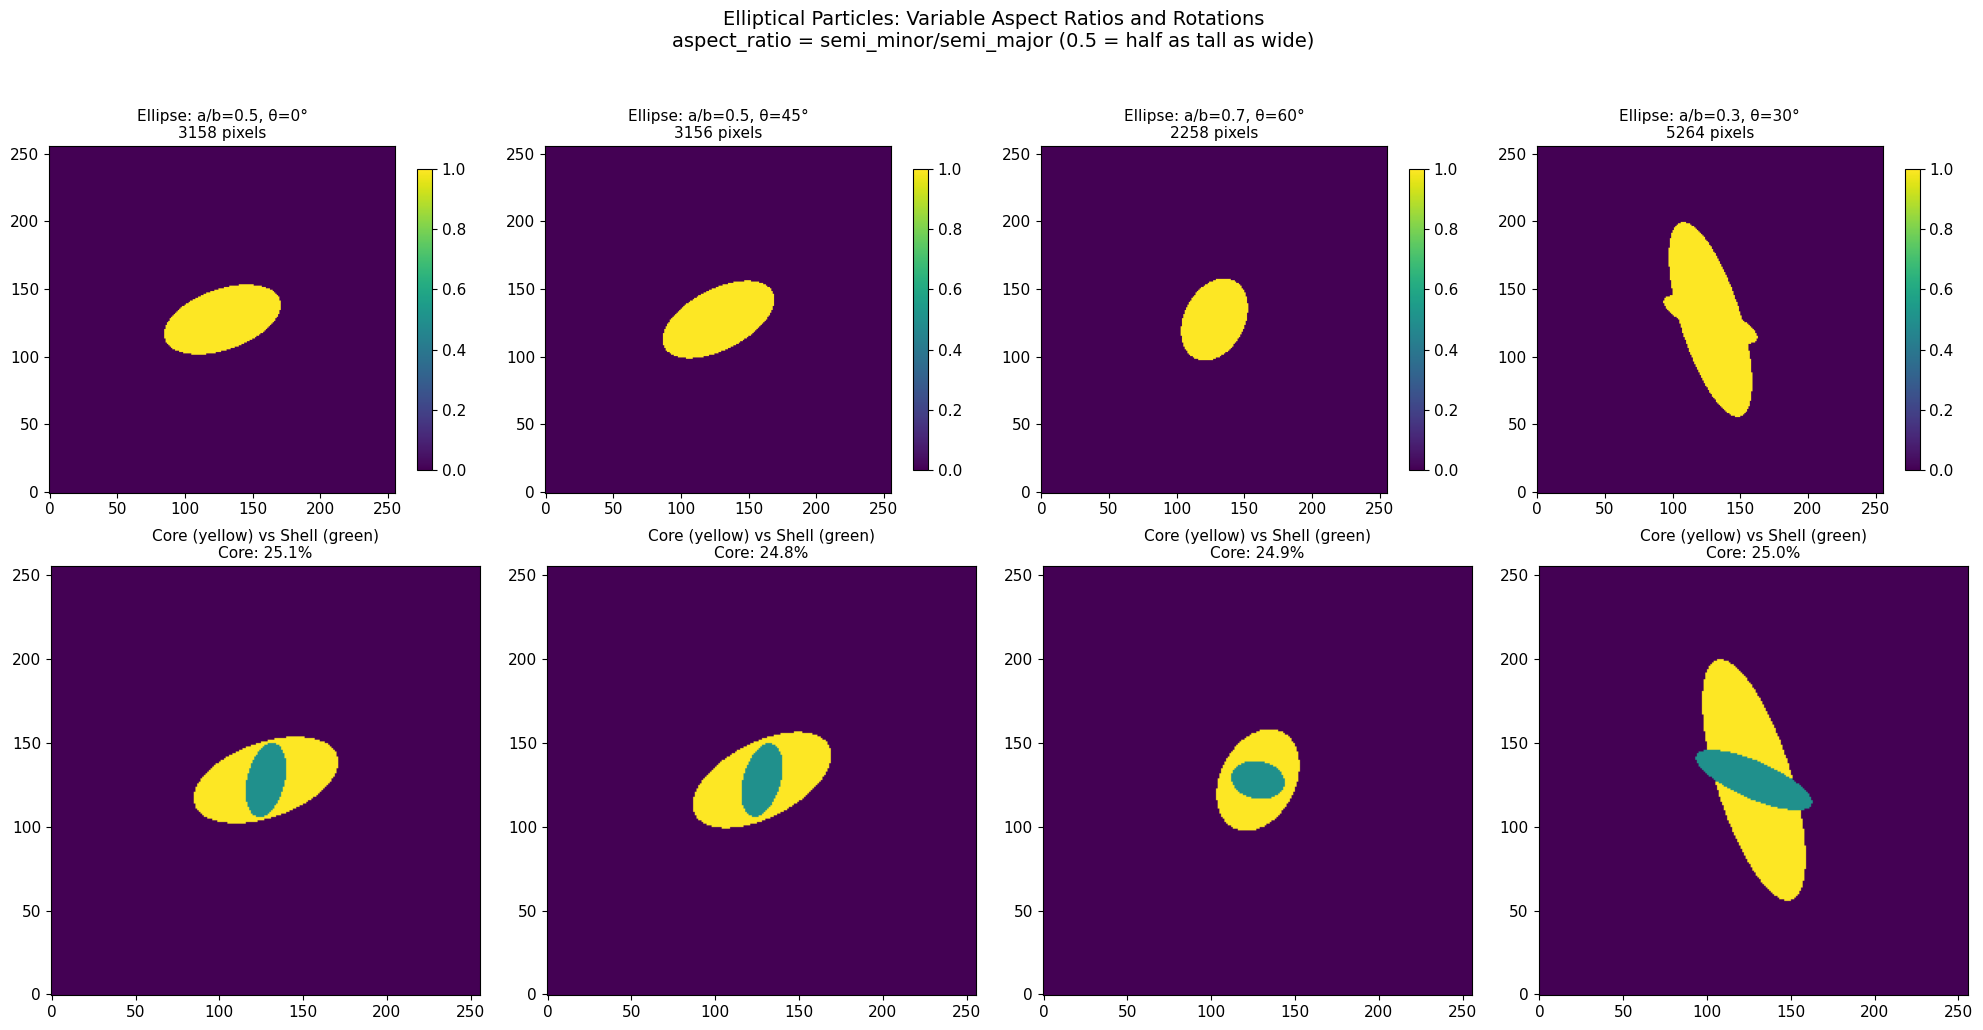

In [6]:
# =============================================================================
# CREATE ELLIPSE PARTICLES WITH VARYING ASPECT RATIOS
# =============================================================================

print("Creating ellipse particles with different aspect ratios and rotations...")
print("="*70)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

ellipse_configs = [
    {'aspect_ratio': 0.5, 'rotation': 0.0, 'name': 'a/b=0.5, θ=0°'},
    {'aspect_ratio': 0.5, 'rotation': np.pi/4, 'name': 'a/b=0.5, θ=45°'},
    {'aspect_ratio': 0.7, 'rotation': np.pi/3, 'name': 'a/b=0.7, θ=60°'},
    {'aspect_ratio': 0.3, 'rotation': np.pi/6, 'name': 'a/b=0.3, θ=30°'},
]

for col, config in enumerate(ellipse_configs):
    particle, info = create_particle_with_shape(
        grid_size=GRID_SIZE,
        shape_type='ellipse',
        outer_radius=45,
        core_fraction=0.5,
        pixel_size=PIXEL_SIZE,
        shape_params={'aspect_ratio': config['aspect_ratio'], 'rotation': config['rotation']},
        verbose=False
    )
    
    # Row 0: Total density
    density = get_total_density(particle)
    im = axes[0, col].imshow(density, cmap='viridis', origin='lower')
    axes[0, col].set_title(f"Ellipse: {config['name']}\n{info['total_area']} pixels", fontsize=11)
    plt.colorbar(im, ax=axes[0, col], shrink=0.7)
    
    # Row 1: Core vs Shell
    combined = np.zeros_like(density)
    combined[info['core_mask']] = 1
    combined[info['shell_mask']] = 2
    im = axes[1, col].imshow(combined, cmap='viridis', origin='lower', vmin=0, vmax=2)
    axes[1, col].set_title(f"Core (yellow) vs Shell (green)\nCore: {info['core_area_fraction']*100:.1f}%", fontsize=11)

plt.suptitle('Elliptical Particles: Variable Aspect Ratios and Rotations\n'
             'aspect_ratio = semi_minor/semi_major (0.5 = half as tall as wide)',
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---

# Part 1C: Composition Modes

Beyond the traditional sharp core-shell boundary, we now support **6 different composition modes** to train the CNN on a wider variety of realistic particle compositions:

| Mode | Description | Physical Example |
|------|-------------|------------------|
| `sharp` | Distinct core-shell boundary | Traditional core-shell nanoparticles |
| `radial_gradient` | Smooth center-to-edge transition | Diffusion-limited particles |
| `linear_gradient` | Composition varies along one axis | Directional growth |
| `janus` | Two-faced left/right split | Janus nanoparticles |
| `multi_shell` | 3+ concentric regions | Onion-like structures |
| `uniform` | Single composition throughout | Pure Ni, Fe, or Ni₃Fe particles |

---

Creating particles with different composition modes...


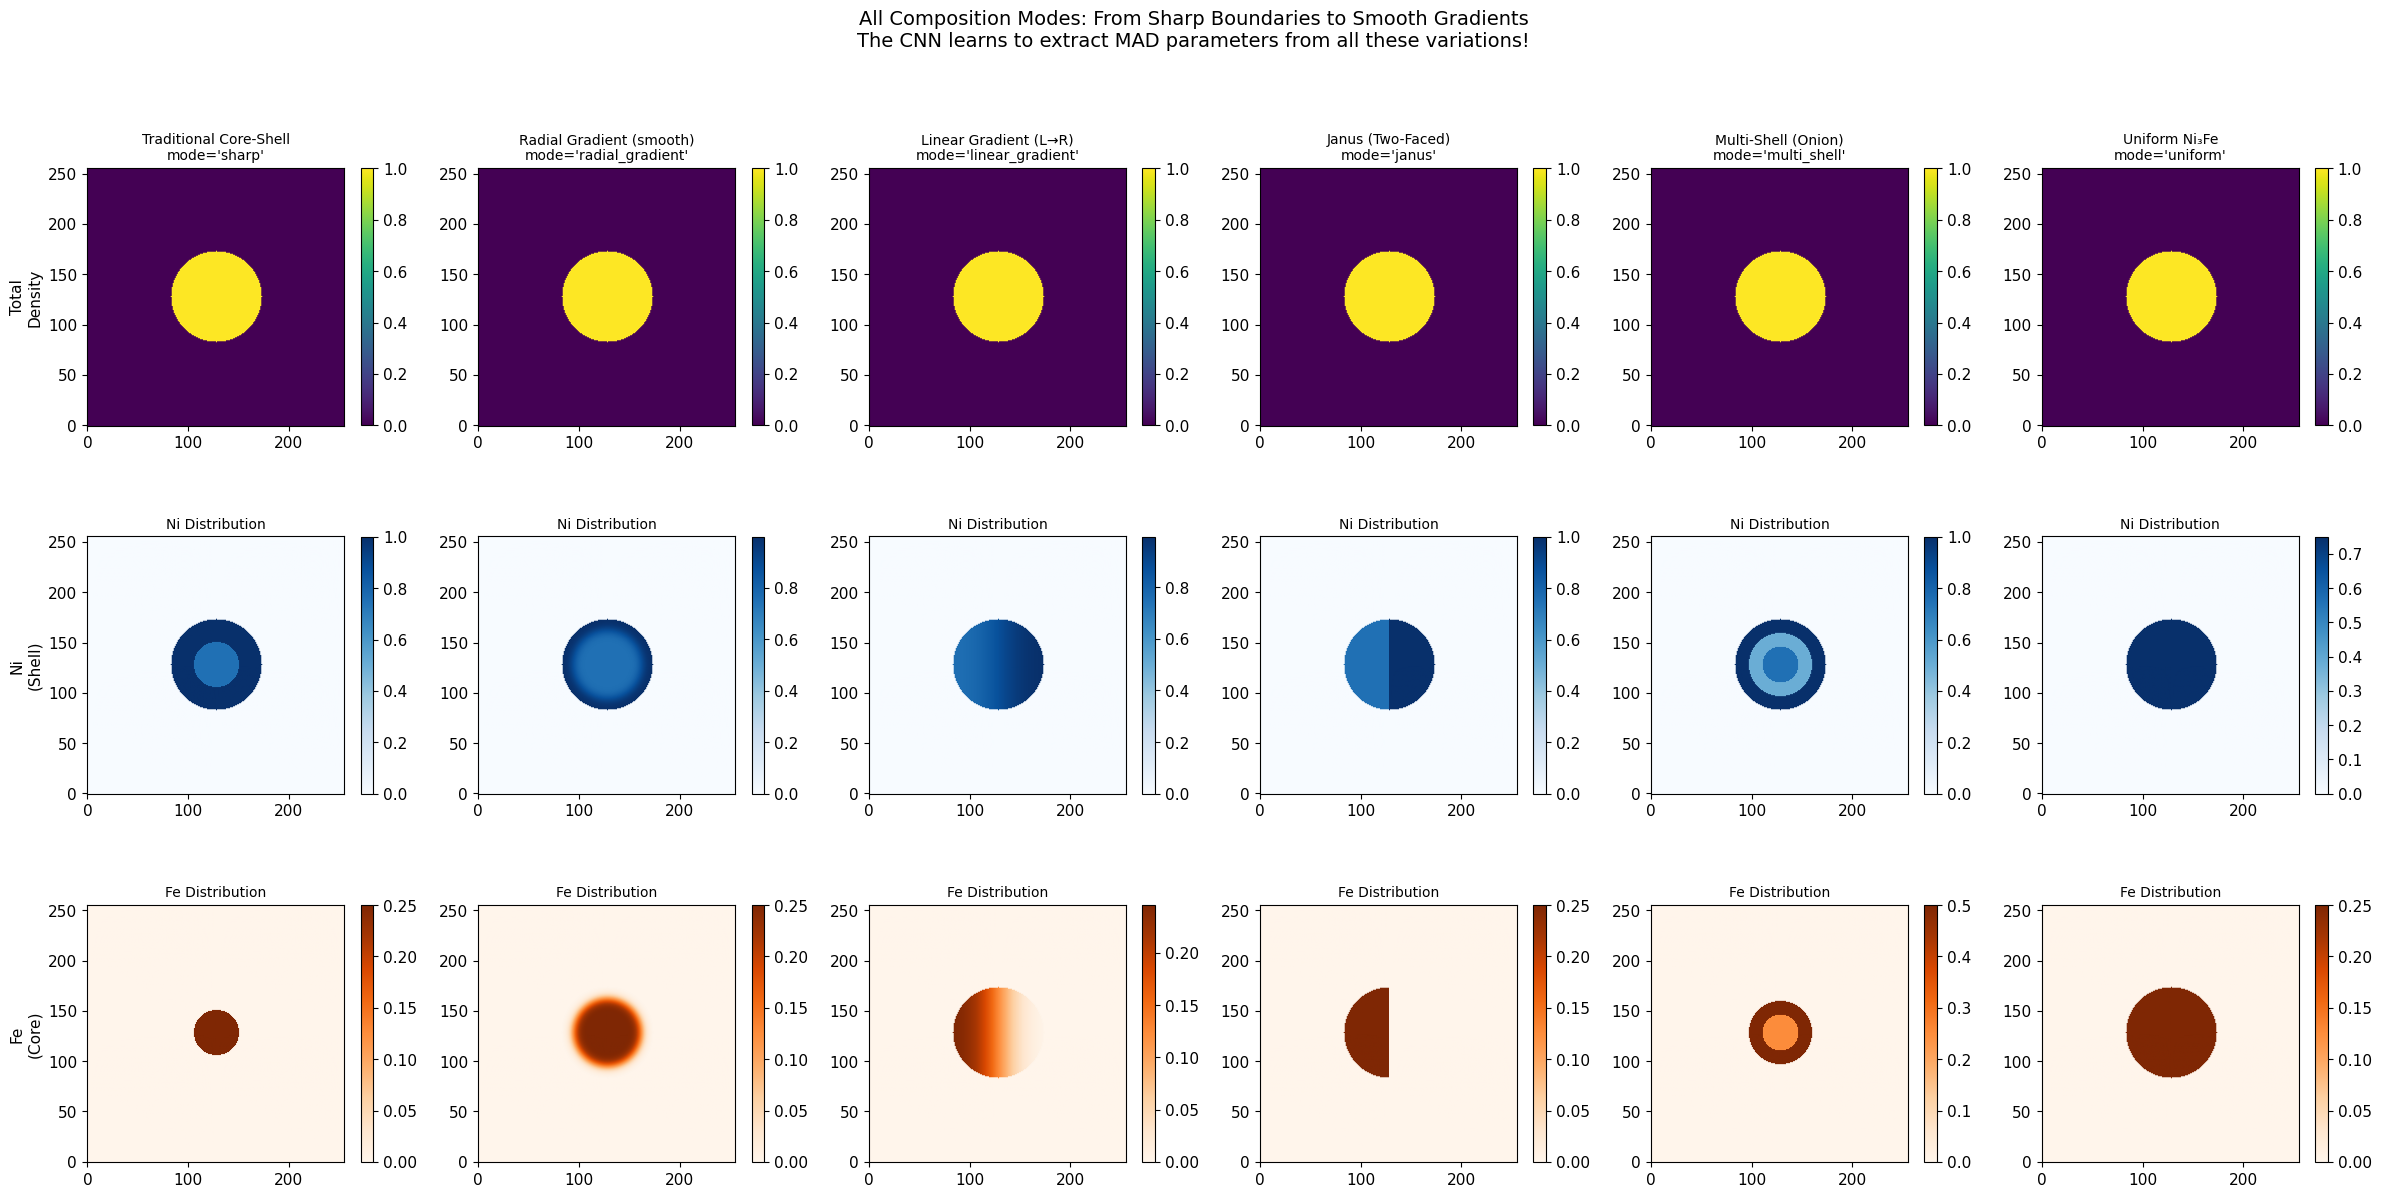

In [7]:
# =============================================================================
# DEMONSTRATE ALL COMPOSITION MODES
# =============================================================================

print("Creating particles with different composition modes...")
print("="*70)

composition_configs = [
    {'mode': 'sharp', 'params': None, 'desc': 'Traditional Core-Shell'},
    {'mode': 'radial_gradient', 'params': {'transition_width': 0.3}, 'desc': 'Radial Gradient (smooth)'},
    {'mode': 'linear_gradient', 'params': {'gradient_direction': 0.0, 'gradient_width': 30.0}, 'desc': 'Linear Gradient (L→R)'},
    {'mode': 'janus', 'params': {'split_angle': 0.0, 'interface_width': 0.0}, 'desc': 'Janus (Two-Faced)'},
    {'mode': 'multi_shell', 'params': {'n_shells': 3, 'transition_width': 0.0}, 'desc': 'Multi-Shell (Onion)'},
    {'mode': 'uniform', 'params': {'composition': {'Ni': 0.75, 'Fe': 0.25}}, 'desc': 'Uniform Ni₃Fe'},
]

fig, axes = plt.subplots(3, 6, figsize=(24, 12))

for col, config in enumerate(composition_configs):
    particle, info = create_particle_with_shape(
        grid_size=GRID_SIZE,
        shape_type='circle',
        outer_radius=45,
        core_fraction=0.5,
        pixel_size=PIXEL_SIZE,
        composition_mode=config['mode'],
        composition_params=config['params'],
        verbose=False
    )
    
    # Row 0: Total density
    density = get_total_density(particle)
    im = axes[0, col].imshow(density, cmap='viridis', origin='lower')
    axes[0, col].set_title(f"{config['desc']}\nmode='{config['mode']}'", fontsize=10)
    plt.colorbar(im, ax=axes[0, col], shrink=0.7)
    
    # Row 1: Ni distribution (shell element)
    im = axes[1, col].imshow(np.real(particle[SPECIES_NI]), cmap='Blues', origin='lower')
    axes[1, col].set_title('Ni Distribution', fontsize=10)
    plt.colorbar(im, ax=axes[1, col], shrink=0.7)
    
    # Row 2: Fe distribution (core element)
    im = axes[2, col].imshow(np.real(particle[SPECIES_FE]), cmap='Oranges', origin='lower')
    axes[2, col].set_title('Fe Distribution', fontsize=10)
    plt.colorbar(im, ax=axes[2, col], shrink=0.7)

axes[0, 0].set_ylabel('Total\nDensity', fontsize=11)
axes[1, 0].set_ylabel('Ni\n(Shell)', fontsize=11)
axes[2, 0].set_ylabel('Fe\n(Core)', fontsize=11)

plt.suptitle('All Composition Modes: From Sharp Boundaries to Smooth Gradients\n'
             'The CNN learns to extract MAD parameters from all these variations!',
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

Creating pure composition particles (uniform, no core-shell)...


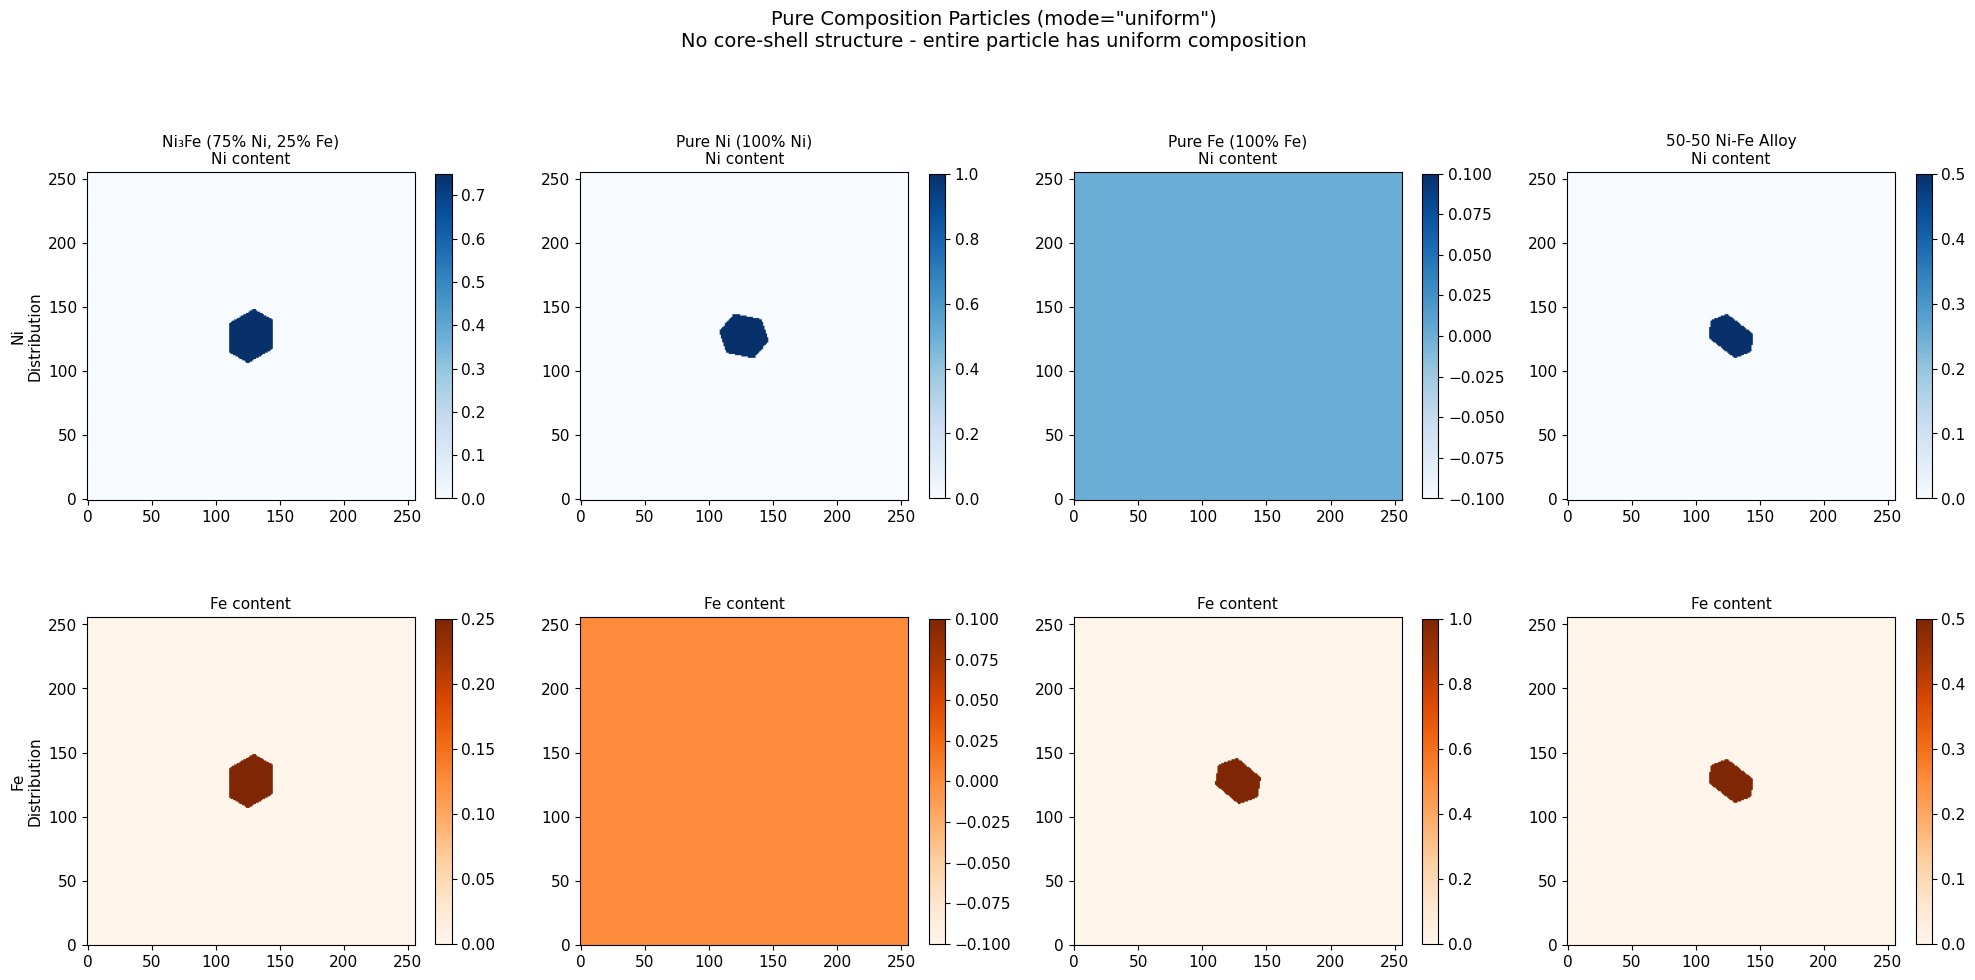

In [8]:
# =============================================================================
# PURE COMPOSITION PARTICLES (No Core-Shell)
# =============================================================================

print("Creating pure composition particles (uniform, no core-shell)...")
print("="*70)

pure_configs = [
    {'composition': {'Ni': 0.75, 'Fe': 0.25}, 'desc': 'Ni₃Fe (75% Ni, 25% Fe)'},
    {'composition': {'Ni': 1.0, 'Fe': 0.0}, 'desc': 'Pure Ni (100% Ni)'},
    {'composition': {'Ni': 0.0, 'Fe': 1.0}, 'desc': 'Pure Fe (100% Fe)'},
    {'composition': {'Ni': 0.5, 'Fe': 0.5}, 'desc': '50-50 Ni-Fe Alloy'},
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for col, config in enumerate(pure_configs):
    particle, info = create_particle_with_shape(
        grid_size=GRID_SIZE,
        shape_type='hexagon',
        outer_radius=40,
        core_fraction=0.5,  # Ignored for uniform mode
        pixel_size=PIXEL_SIZE,
        composition_mode='uniform',
        composition_params={'composition': config['composition']},
        verbose=False
    )
    
    # Row 0: Ni distribution
    ni_real = np.real(particle[SPECIES_NI])
    im = axes[0, col].imshow(ni_real, cmap='Blues', origin='lower')
    axes[0, col].set_title(f"{config['desc']}\nNi content", fontsize=11)
    plt.colorbar(im, ax=axes[0, col], shrink=0.7)
    
    # Row 1: Fe distribution
    fe_real = np.real(particle[SPECIES_FE])
    im = axes[1, col].imshow(fe_real, cmap='Oranges', origin='lower')
    axes[1, col].set_title(f"Fe content", fontsize=11)
    plt.colorbar(im, ax=axes[1, col], shrink=0.7)

axes[0, 0].set_ylabel('Ni\nDistribution', fontsize=11)
axes[1, 0].set_ylabel('Fe\nDistribution', fontsize=11)

plt.suptitle('Pure Composition Particles (mode="uniform")\n'
             'No core-shell structure - entire particle has uniform composition',
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---

## Part 1D: Geometry Modifiers

Beyond shape and composition, we can apply **geometry modifiers** to create even more realistic particle variations:

| Modifier | Description | Physical Example |
|----------|-------------|------------------|
| **Winterbottom Truncation** | Flat facet cut at any angle/depth | Particles grown on substrate |
| **Off-Center Core** | Eccentric core placement | Asymmetric nucleation |
| **Size Variation** | 0.7x to 1.3x radius scaling | Natural size distribution |

---

Creating particles with Winterbottom truncation...


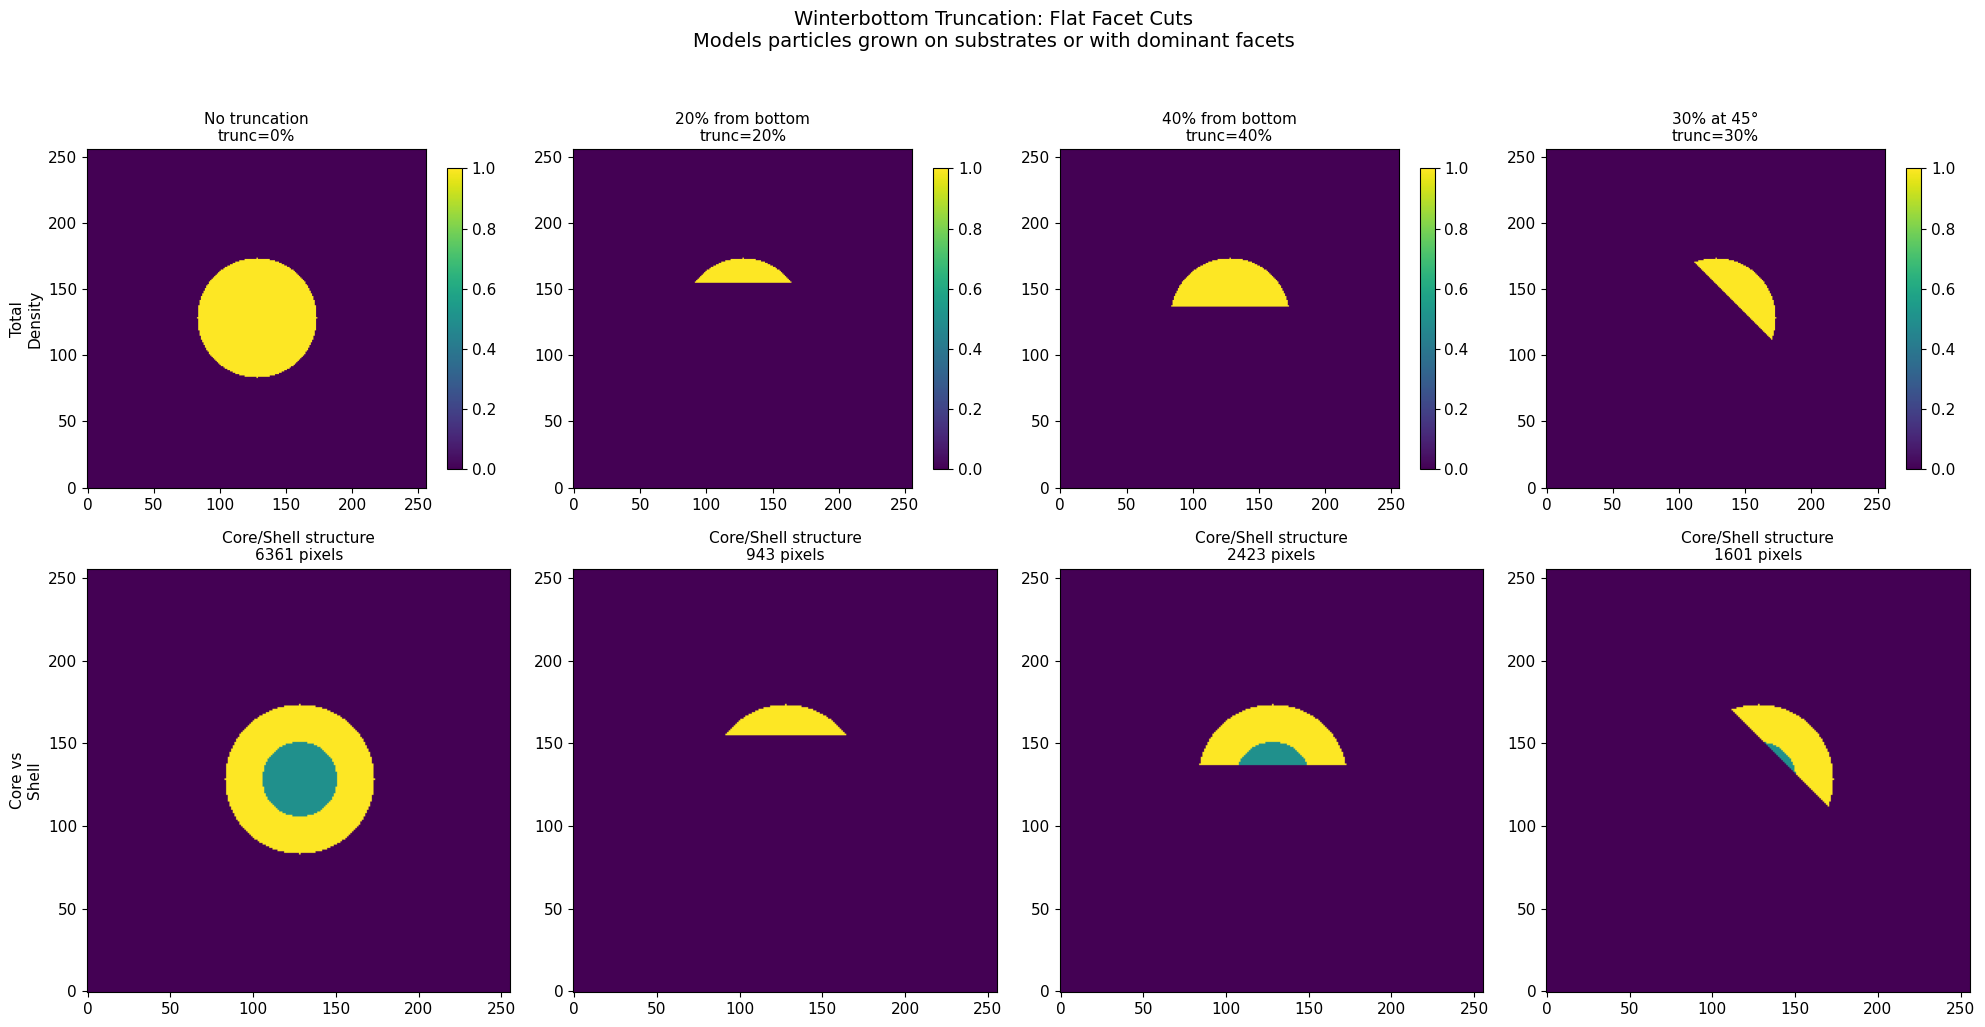

In [9]:
# =============================================================================
# WINTERBOTTOM TRUNCATION - Particles with Flat Facets
# =============================================================================

print("Creating particles with Winterbottom truncation...")
print("="*70)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

truncation_configs = [
    {'frac': 0.0, 'angle': 0.0, 'desc': 'No truncation'},
    {'frac': 0.2, 'angle': 0.0, 'desc': '20% from bottom'},
    {'frac': 0.4, 'angle': 0.0, 'desc': '40% from bottom'},
    {'frac': 0.3, 'angle': np.pi/4, 'desc': '30% at 45°'},
]

for col, config in enumerate(truncation_configs):
    particle, info = create_particle_with_shape(
        grid_size=GRID_SIZE,
        shape_type='circle',
        outer_radius=45,
        core_fraction=0.5,
        pixel_size=PIXEL_SIZE,
        truncation_fraction=config['frac'],
        truncation_angle=config['angle'],
        verbose=False
    )
    
    # Row 0: Total density
    density = get_total_density(particle)
    im = axes[0, col].imshow(density, cmap='viridis', origin='lower')
    axes[0, col].set_title(f"{config['desc']}\ntrunc={config['frac']:.0%}", fontsize=11)
    plt.colorbar(im, ax=axes[0, col], shrink=0.7)
    
    # Row 1: Core vs Shell
    combined = np.zeros_like(density)
    combined[info['core_mask']] = 1
    combined[info['shell_mask']] = 2
    im = axes[1, col].imshow(combined, cmap='viridis', origin='lower', vmin=0, vmax=2)
    axes[1, col].set_title(f"Core/Shell structure\n{info['outer_mask'].sum()} pixels", fontsize=11)

axes[0, 0].set_ylabel('Total\nDensity', fontsize=11)
axes[1, 0].set_ylabel('Core vs\nShell', fontsize=11)

plt.suptitle('Winterbottom Truncation: Flat Facet Cuts\n'
             'Models particles grown on substrates or with dominant facets',
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

Creating particles with off-center (eccentric) cores...


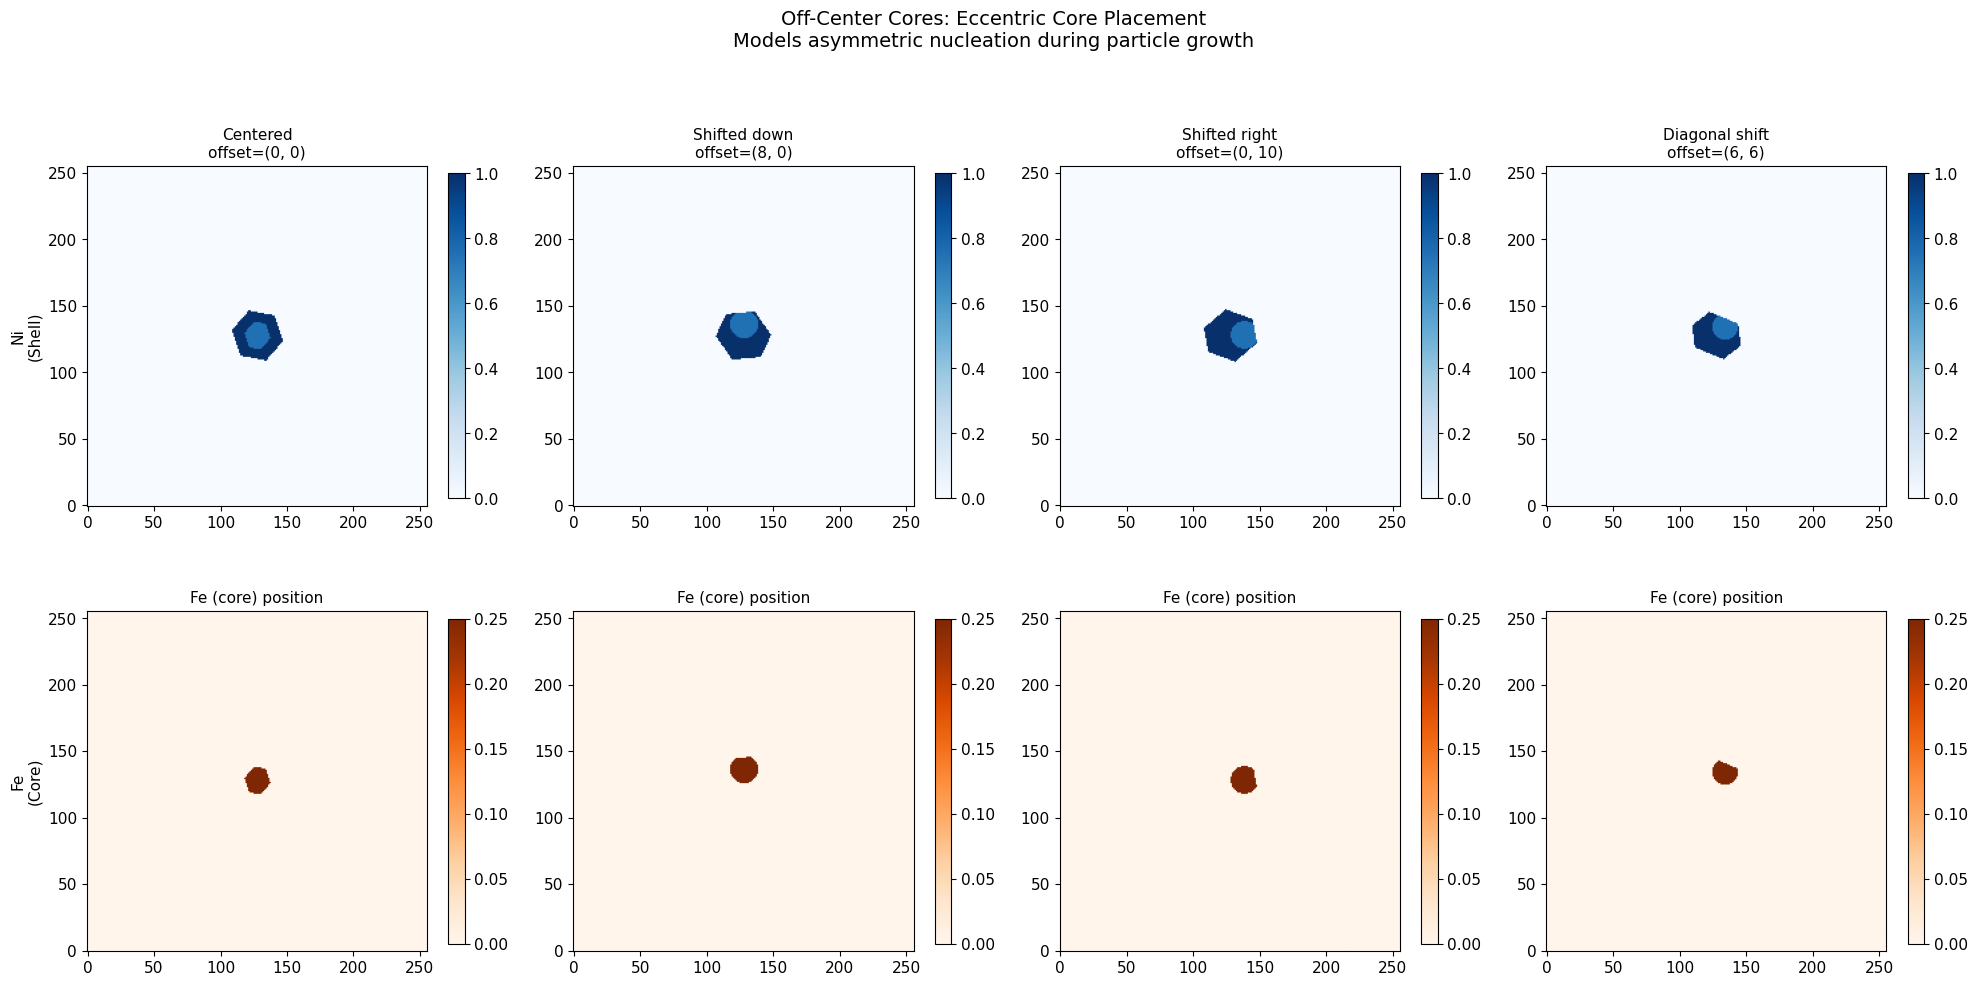

In [10]:
# =============================================================================
# OFF-CENTER CORES - Eccentric Core Placement
# =============================================================================

print("Creating particles with off-center (eccentric) cores...")
print("="*70)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

offset_configs = [
    {'offset': (0, 0), 'desc': 'Centered'},
    {'offset': (8, 0), 'desc': 'Shifted down'},
    {'offset': (0, 10), 'desc': 'Shifted right'},
    {'offset': (6, 6), 'desc': 'Diagonal shift'},
]

for col, config in enumerate(offset_configs):
    particle, info = create_particle_with_shape(
        grid_size=GRID_SIZE,
        shape_type='hexagon',
        outer_radius=40,
        core_fraction=0.5,
        pixel_size=PIXEL_SIZE,
        core_offset=config['offset'],
        verbose=False
    )
    
    # Row 0: Ni distribution (shows shell)
    ni_real = np.real(particle[SPECIES_NI])
    im = axes[0, col].imshow(ni_real, cmap='Blues', origin='lower')
    axes[0, col].set_title(f"{config['desc']}\noffset={config['offset']}", fontsize=11)
    plt.colorbar(im, ax=axes[0, col], shrink=0.7)
    
    # Row 1: Fe distribution (shows core position)
    fe_real = np.real(particle[SPECIES_FE])
    im = axes[1, col].imshow(fe_real, cmap='Oranges', origin='lower')
    axes[1, col].set_title(f"Fe (core) position", fontsize=11)
    plt.colorbar(im, ax=axes[1, col], shrink=0.7)

axes[0, 0].set_ylabel('Ni\n(Shell)', fontsize=11)
axes[1, 0].set_ylabel('Fe\n(Core)', fontsize=11)

plt.suptitle('Off-Center Cores: Eccentric Core Placement\n'
             'Models asymmetric nucleation during particle growth',
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

Creating gallery of combined particle variations...


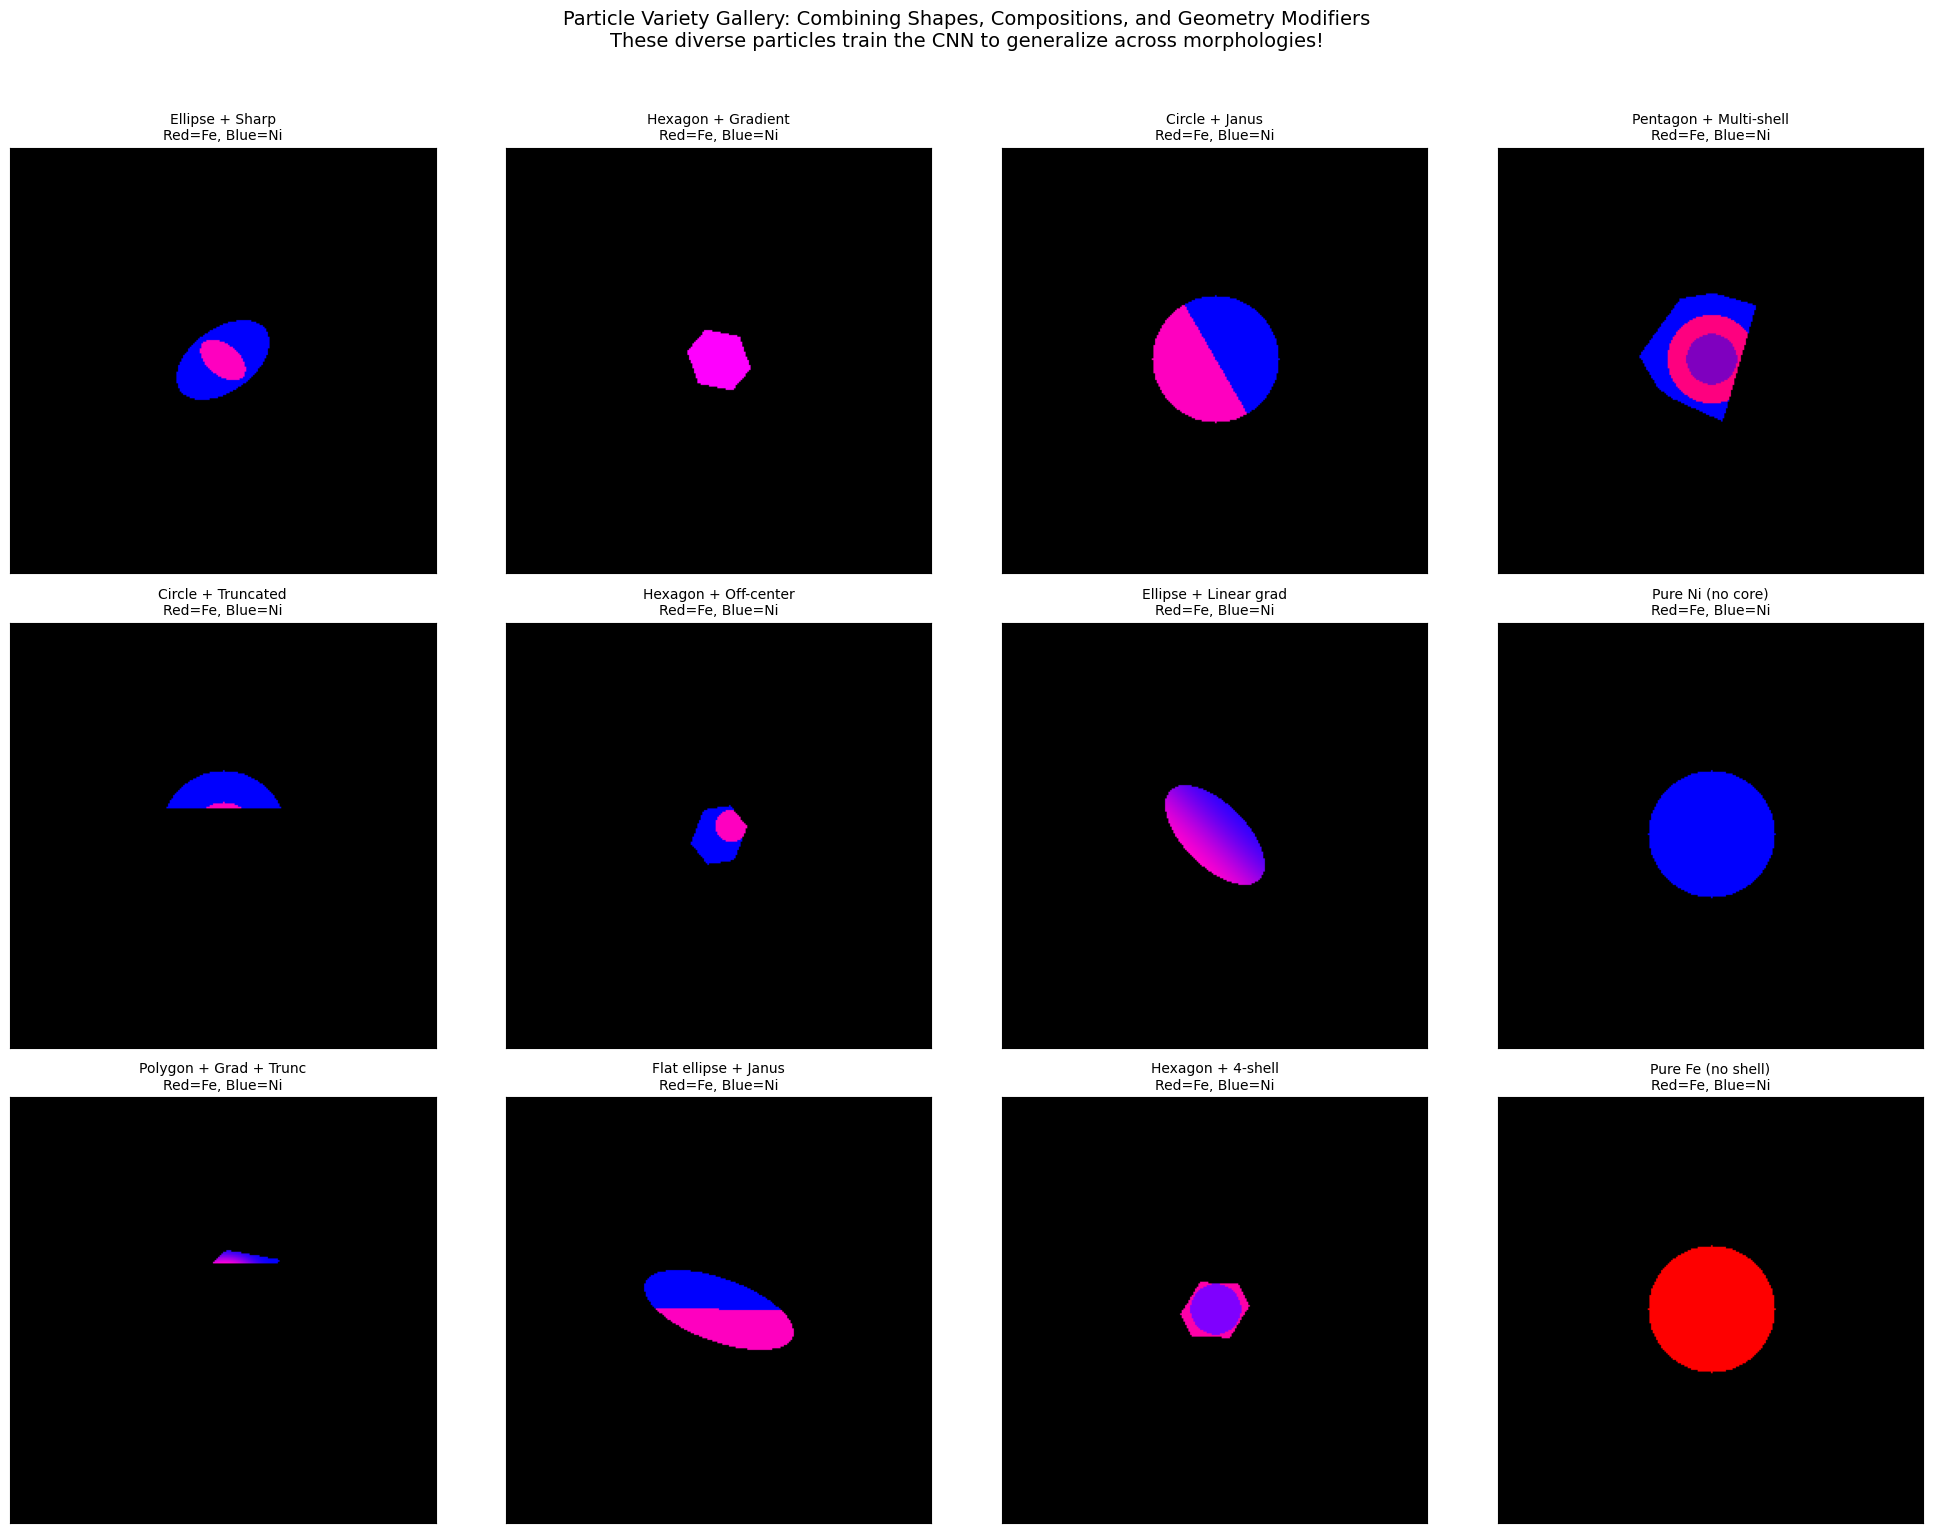


This gallery shows the full diversity of synthetic particles available for training:
  - 5 shape types (circle, hexagon, polygon, polygon_centrosymmetric, ellipse)
  - 6 composition modes (sharp, radial_gradient, linear_gradient, janus, multi_shell, uniform)
  - Geometry modifiers (Winterbottom truncation, off-center cores)
  - Size variation (0.7x to 1.3x scaling)

The CNN learns from all these variations to generalize to real experimental data!


In [11]:
# =============================================================================
# COMBINED VARIETY GALLERY - Multiple Features Together
# =============================================================================

print("Creating gallery of combined particle variations...")
print("="*70)

# Generate 12 diverse particles combining different features
np.random.seed(123)

gallery_configs = [
    # Row 1: Shapes with different compositions
    {'shape': 'ellipse', 'mode': 'sharp', 'params': {'aspect_ratio': 0.6, 'rotation': 0.3}, 
     'comp_params': None, 'desc': 'Ellipse + Sharp'},
    {'shape': 'hexagon', 'mode': 'radial_gradient', 'params': {'anisotropy': 1.1}, 
     'comp_params': {'transition_width': 0.25}, 'desc': 'Hexagon + Gradient'},
    {'shape': 'circle', 'mode': 'janus', 'params': {}, 
     'comp_params': {'split_angle': np.pi/6, 'interface_width': 0.0}, 'desc': 'Circle + Janus'},
    {'shape': 'polygon', 'mode': 'multi_shell', 'params': {'n_vertices': 5}, 
     'comp_params': {'n_shells': 3, 'transition_width': 0.0}, 'desc': 'Pentagon + Multi-shell'},
    
    # Row 2: With geometry modifiers
    {'shape': 'circle', 'mode': 'sharp', 'params': {}, 
     'comp_params': None, 'trunc': 0.3, 'desc': 'Circle + Truncated'},
    {'shape': 'hexagon', 'mode': 'sharp', 'params': {}, 
     'comp_params': None, 'offset': (5, 7), 'desc': 'Hexagon + Off-center'},
    {'shape': 'ellipse', 'mode': 'linear_gradient', 'params': {'aspect_ratio': 0.5, 'rotation': np.pi/3}, 
     'comp_params': {'gradient_direction': np.pi/4, 'gradient_width': 25.0}, 'desc': 'Ellipse + Linear grad'},
    {'shape': 'circle', 'mode': 'uniform', 'params': {}, 
     'comp_params': {'composition': {'Ni': 1.0, 'Fe': 0.0}}, 'desc': 'Pure Ni (no core)'},
    
    # Row 3: More combinations
    {'shape': 'polygon_centrosymmetric', 'mode': 'radial_gradient', 'params': {'n_vertices': 6}, 
     'comp_params': {'transition_width': 0.4}, 'trunc': 0.2, 'desc': 'Polygon + Grad + Trunc'},
    {'shape': 'ellipse', 'mode': 'janus', 'params': {'aspect_ratio': 0.4, 'rotation': 0}, 
     'comp_params': {'split_angle': np.pi/2, 'interface_width': 0.0}, 'desc': 'Flat ellipse + Janus'},
    {'shape': 'hexagon', 'mode': 'multi_shell', 'params': {'anisotropy': 1.2}, 
     'comp_params': {'n_shells': 4, 'transition_width': 0.0}, 'desc': 'Hexagon + 4-shell'},
    {'shape': 'circle', 'mode': 'uniform', 'params': {}, 
     'comp_params': {'composition': {'Ni': 0.0, 'Fe': 1.0}}, 'desc': 'Pure Fe (no shell)'},
]

fig, axes = plt.subplots(3, 4, figsize=(20, 15))

for idx, config in enumerate(gallery_configs):
    row, col = idx // 4, idx % 4
    
    particle, info = create_particle_with_shape(
        grid_size=GRID_SIZE,
        shape_type=config['shape'],
        outer_radius=38,
        core_fraction=0.5,
        pixel_size=PIXEL_SIZE,
        shape_params=config['params'],
        composition_mode=config['mode'],
        composition_params=config['comp_params'],
        truncation_fraction=config.get('trunc', 0.0),
        core_offset=config.get('offset', (0, 0)),
        verbose=False
    )
    
    # Show Fe distribution (highlights composition variation)
    fe_real = np.real(particle[SPECIES_FE])
    ni_real = np.real(particle[SPECIES_NI])
    
    # Create RGB composite: Red=Fe, Blue=Ni
    rgb = np.zeros((GRID_SIZE, GRID_SIZE, 3))
    fe_norm = fe_real / (fe_real.max() + 1e-10)
    ni_norm = ni_real / (ni_real.max() + 1e-10)
    rgb[:,:,0] = fe_norm  # Red channel = Fe
    rgb[:,:,2] = ni_norm  # Blue channel = Ni
    
    axes[row, col].imshow(rgb, origin='lower')
    axes[row, col].set_title(f"{config['desc']}\nRed=Fe, Blue=Ni", fontsize=10)
    axes[row, col].set_xticks([])
    axes[row, col].set_yticks([])

plt.suptitle('Particle Variety Gallery: Combining Shapes, Compositions, and Geometry Modifiers\n'
             'These diverse particles train the CNN to generalize across morphologies!',
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\nThis gallery shows the full diversity of synthetic particles available for training:")
print("  - 5 shape types (circle, hexagon, polygon, polygon_centrosymmetric, ellipse)")
print("  - 6 composition modes (sharp, radial_gradient, linear_gradient, janus, multi_shell, uniform)")
print("  - Geometry modifiers (Winterbottom truncation, off-center cores)")
print("  - Size variation (0.7x to 1.3x scaling)")
print("\nThe CNN learns from all these variations to generalize to real experimental data!")

---

# Part 2: Strain Field Layers

In BCDI, we measure **both amplitude AND phase** of the scattered wave. The phase encodes the **displacement field** (strain) inside the particle:

$$\phi(\mathbf{r}) = \mathbf{Q}_{Bragg} \cdot \mathbf{u}(\mathbf{r})$$

Where:
- $\phi(\mathbf{r})$ = Phase at position r
- $\mathbf{Q}_{Bragg}$ = Bragg peak wavevector (defines which lattice planes we're sensitive to)
- $\mathbf{u}(\mathbf{r})$ = Displacement field (how much atoms have moved from ideal positions)

## Strain Sources in Core-Shell Particles

We model **four physical sources** of strain:

| Layer | Physical Origin | Description |
|-------|-----------------|-------------|
| **Interface Strain** | Lattice mismatch | Fe and Ni have slightly different lattice parameters (~0.6% mismatch). The core-shell interface is strained. |
| **Surface Relaxation** | Surface energy | Atoms at the surface relax outward to minimize surface energy. Decays exponentially into the bulk. |
| **Corner Enhancement** | Geometry | Corners and edges have higher strain due to geometric constraints. Faceted particles show enhanced strain at vertices. |
| **Random Strain** | Defects/disorder | Real particles have random strain variations from defects, dislocations, vacancies, etc. |

These layers are **combined** to give the total displacement field, which then determines the phase.

---

In [12]:
# =============================================================================
# VISUALIZE STRAIN LAYERS FOR ALL PARTICLE TYPES
# =============================================================================
# We'll create the strain field layer by layer and visualize each component

def create_and_visualize_strain_layers(particle, info, shape_type):
    """
    Create strain field layers and return them separately for visualization.
    
    Returns dict with:
        - analytic: Combined analytic displacement (interface + surface with corner enhancement)
        - random: Random strain field
        - total: Final combined displacement field
        - info: Additional info from the layered displacement function
    """
    outer_mask = info['outer_mask']
    core_mask = info['core_mask']
    outer_vertices = info.get('outer_vertices', [])
    
    # Get the analytic displacement field with verbose output
    print(f"\n{'='*70}")
    print(f"STRAIN LAYERS FOR: {shape_type.upper()}")
    print(f"{'='*70}")
    
    # Create the layered displacement field
    # This function internally computes interface, surface, and corner layers
    displacement_analytic, disp_info = create_layered_displacement_field(
        core_mask=core_mask,
        outer_mask=outer_mask,
        pixel_size=PIXEL_SIZE,
        interface_amplitude=1.5,   # Interface mismatch amplitude (Angstroms)
        surface_amplitude=0.8,     # Surface relaxation amplitude (Angstroms)
        corner_positions=outer_vertices,
        corner_enhancement=0.3,    # Corner enhancement factor
        verbose=True
    )
    
    # Create random strain field
    displacement_random = create_random_strain_field(
        grid_size=GRID_SIZE,
        pixel_size=PIXEL_SIZE,
        displacement_amplitude=0.3,   # Random strain amplitude (Angstroms)
        correlation_length=0.08,      # Spatial correlation (fraction of grid)
        verbose=True
    )
    
    # Total displacement
    displacement_total = displacement_analytic + displacement_random
    
    # Extract individual layers from disp_info if available
    # (The function stores intermediate results)
    layers = {
        'analytic': displacement_analytic,
        'random': displacement_random,
        'total': displacement_total,
        'info': disp_info,
    }
    
    return layers

In [13]:
# Create strain layers for each particle type
strain_layers = {}

for shape_type in particle_types:
    strain_layers[shape_type] = create_and_visualize_strain_layers(
        particles[shape_type], 
        particle_infos[shape_type],
        shape_type
    )


STRAIN LAYERS FOR: CIRCLE

  Creating layered displacement field (shape-aware)...
    Grid size: 256×256
    Pixel size: 5.0 Å

    Layer 1: Interface strain (core-shell mismatch)
      Lattice mismatch: 0.60%
    Signed distance field computed:
      Inside range: [-100.1, -5.0] (negative)
      Outside range: [5.0, 806.1] (positive)
      Interface displacement range: [-0.300, 0.302] Å

    Layer 2: Surface relaxation
      Amplitude: 0.80 Å
    Surface relaxation field computed:
      Relaxation depth: 50.0 Å
      Field range (inside): [0.020, 1.000]

    Corner enhancement (multiplicative)
      Enhancement amplitude: 0.30
      No corner positions provided - skipping corner enhancement

    Combined displacement field:
      Total range: [-0.284, 1.102] Å
      RMS displacement: 0.370 Å

  Random strain field created (Robinson-style):
    Displacement amplitude: ±0.300 Å
    Correlation length: 0.08 (normalized)
    Correlation length: 102.4 Å (physical)
    Displacement range: 

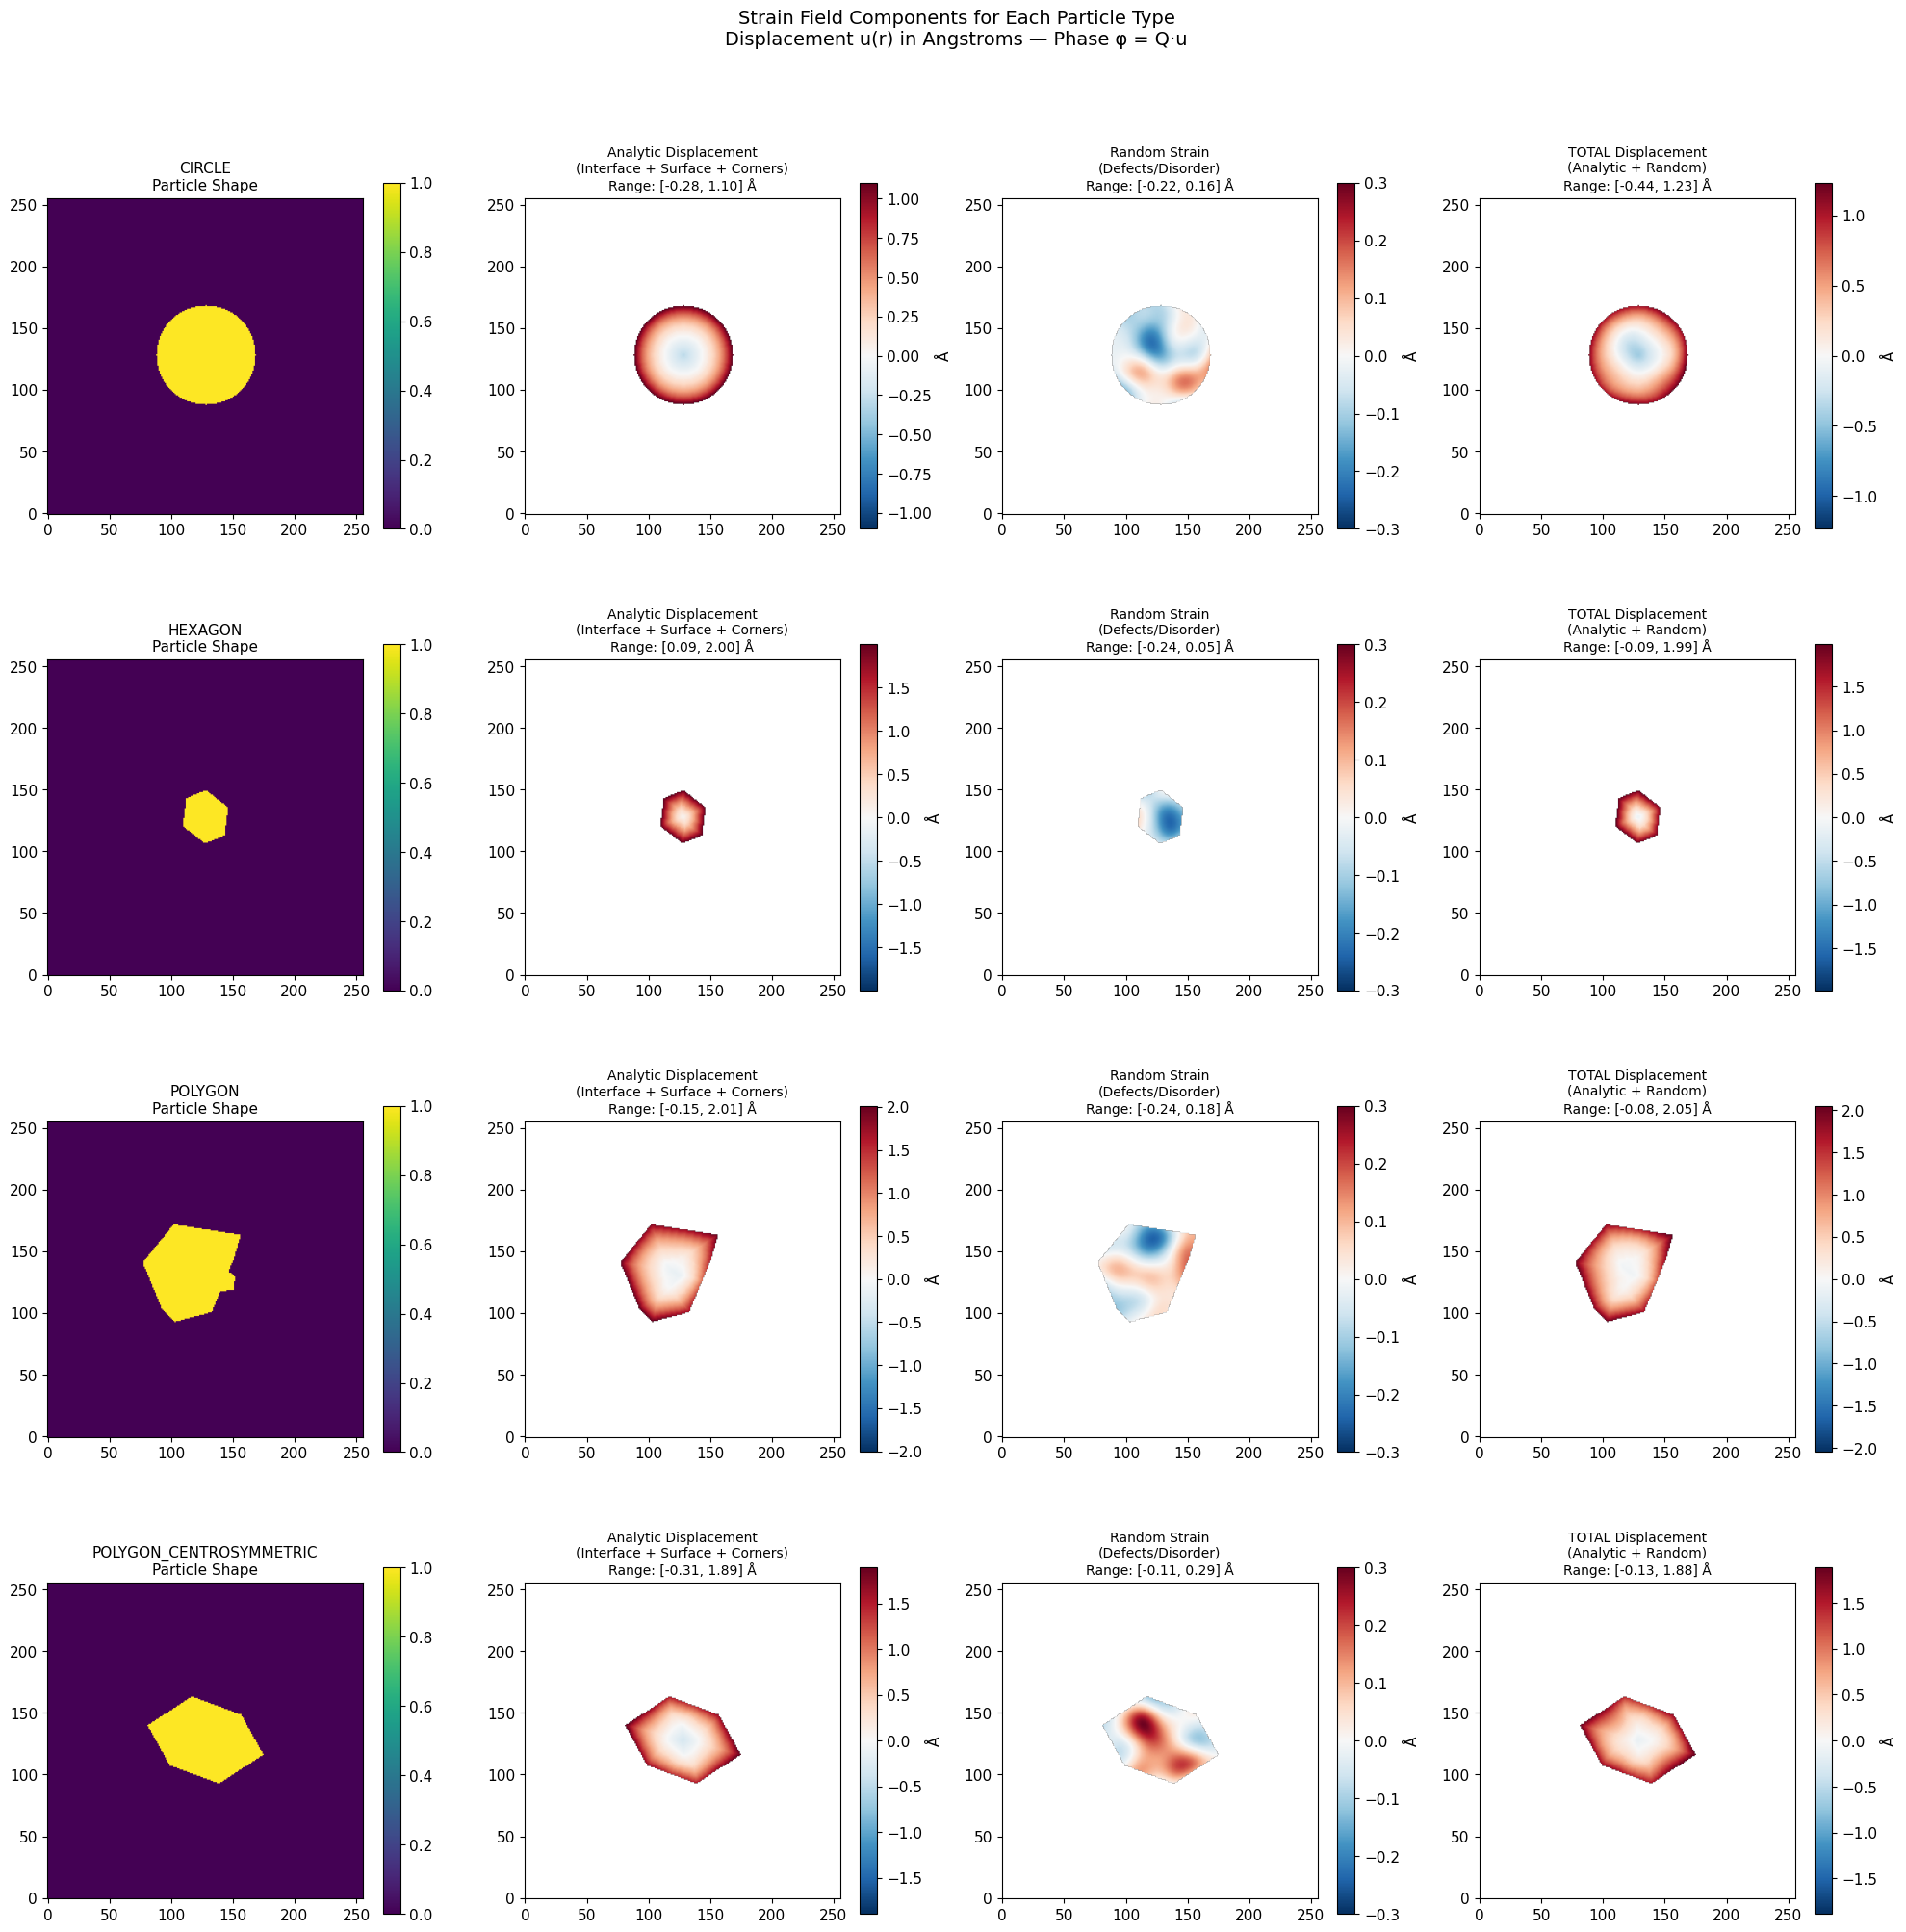

In [14]:
# =============================================================================
# VISUALIZE STRAIN LAYERS FOR ALL PARTICLES
# =============================================================================

fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for row, shape_type in enumerate(particle_types):
    particle = particles[shape_type]
    info = particle_infos[shape_type]
    layers = strain_layers[shape_type]
    
    # Create mask for display (only show inside particle)
    mask = info['outer_mask']
    
    # Column 0: Particle density (reference)
    density = get_total_density(particle)
    im = axes[row, 0].imshow(density, cmap='viridis', origin='lower')
    axes[row, 0].set_title(f'{shape_type.upper()}\nParticle Shape', fontsize=11)
    plt.colorbar(im, ax=axes[row, 0], shrink=0.8)
    
    # Column 1: Analytic displacement (interface + surface + corners)
    disp_analytic = np.where(mask, layers['analytic'], np.nan)
    vmax = np.nanmax(np.abs(layers['analytic']))
    im = axes[row, 1].imshow(disp_analytic, cmap='RdBu_r', origin='lower', 
                             vmin=-vmax, vmax=vmax)
    axes[row, 1].set_title(f'Analytic Displacement\n(Interface + Surface + Corners)\nRange: [{np.nanmin(disp_analytic):.2f}, {np.nanmax(disp_analytic):.2f}] Å', fontsize=10)
    plt.colorbar(im, ax=axes[row, 1], shrink=0.8, label='Å')
    
    # Column 2: Random strain
    disp_random = np.where(mask, layers['random'], np.nan)
    vmax_rand = np.nanmax(np.abs(layers['random']))
    im = axes[row, 2].imshow(disp_random, cmap='RdBu_r', origin='lower',
                             vmin=-vmax_rand, vmax=vmax_rand)
    axes[row, 2].set_title(f'Random Strain\n(Defects/Disorder)\nRange: [{np.nanmin(disp_random):.2f}, {np.nanmax(disp_random):.2f}] Å', fontsize=10)
    plt.colorbar(im, ax=axes[row, 2], shrink=0.8, label='Å')
    
    # Column 3: Total displacement
    disp_total = np.where(mask, layers['total'], np.nan)
    vmax_total = np.nanmax(np.abs(layers['total']))
    im = axes[row, 3].imshow(disp_total, cmap='RdBu_r', origin='lower',
                             vmin=-vmax_total, vmax=vmax_total)
    axes[row, 3].set_title(f'TOTAL Displacement\n(Analytic + Random)\nRange: [{np.nanmin(disp_total):.2f}, {np.nanmax(disp_total):.2f}] Å', fontsize=10)
    plt.colorbar(im, ax=axes[row, 3], shrink=0.8, label='Å')

plt.suptitle('Strain Field Components for Each Particle Type\n'
             'Displacement u(r) in Angstroms — Phase φ = Q·u', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Understanding the Strain → Phase Relationship

The displacement field $u(\mathbf{r})$ creates a **phase** in the scattered wave:

$$\phi(\mathbf{r}) = Q_{Bragg} \cdot u(\mathbf{r})$$

For our Ni 111 reflection:
- $Q_{Bragg} \approx 3.09$ Å⁻¹
- A displacement of $u = 1$ Å gives phase $\phi = 3.09$ rad ≈ 177°
- A displacement of $u = 2$ Å gives phase $\phi = 6.18$ rad ≈ 354° (almost full cycle!)

This is why small displacements (Angstroms) create large phase variations (radians).

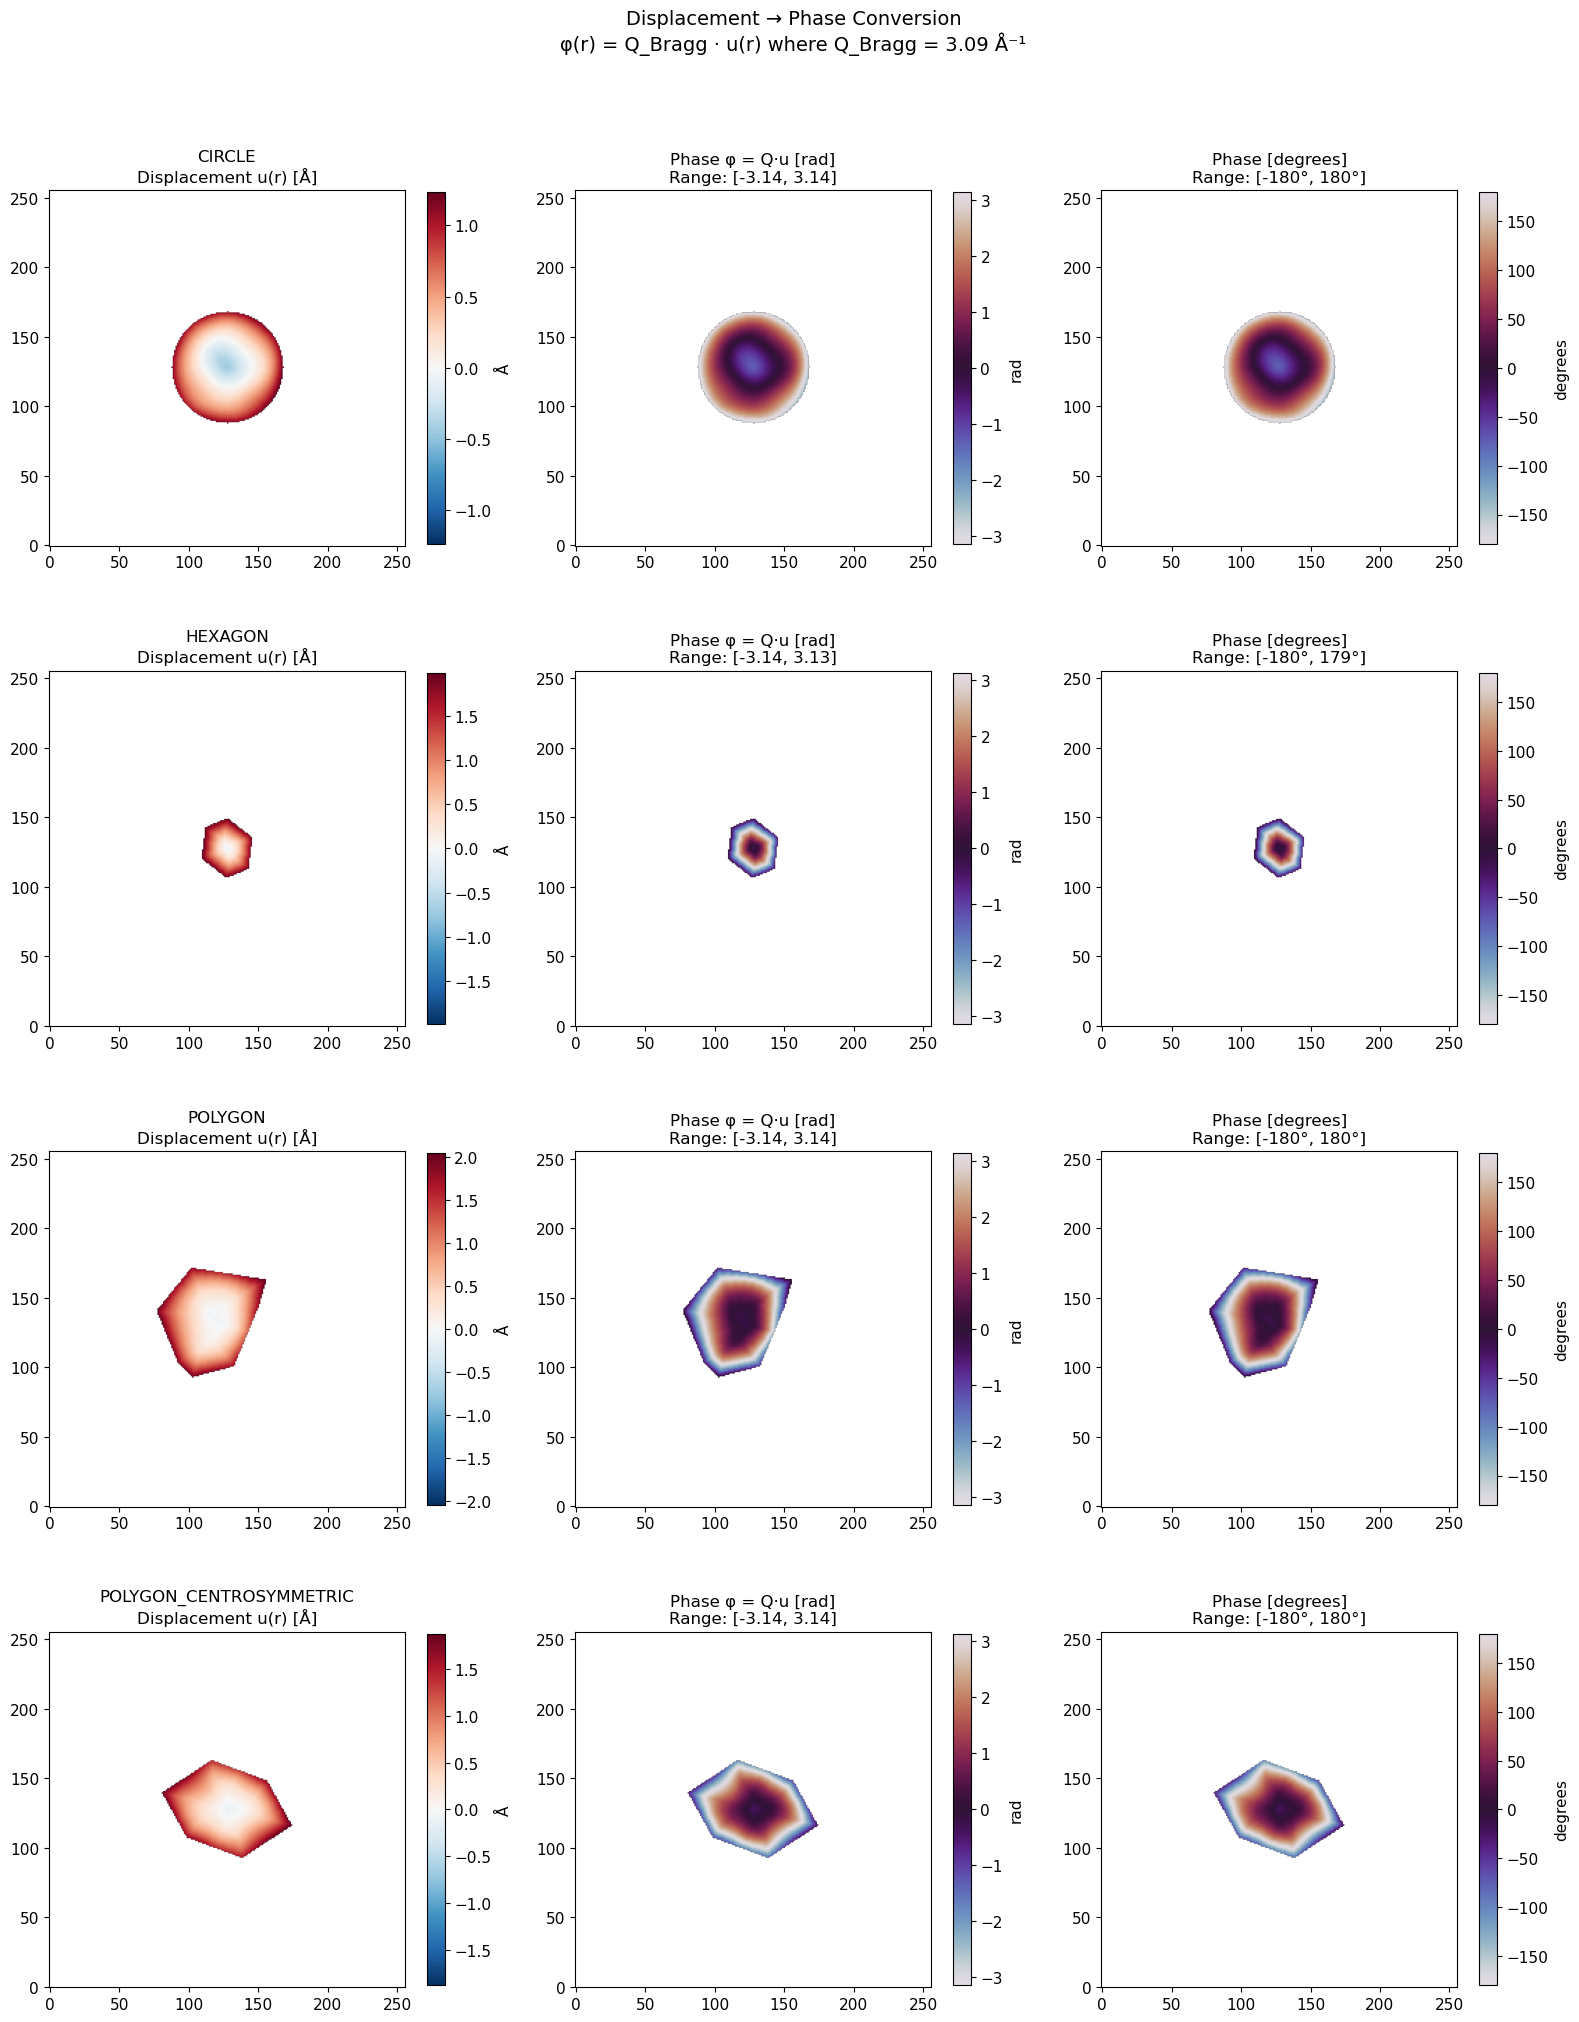


DISPLACEMENT → PHASE CONVERSION
Q_Bragg = 3.09 Å⁻¹

Example conversions:
  u = 0.5 Å  →  φ = 1.54 rad = 89°
  u = 1.0 Å  →  φ = 3.09 rad = 177°
  u = 2.0 Å  →  φ = 6.18 rad = 354°

One full phase cycle (2π = 360°) corresponds to u = 2.03 Å


In [15]:
# =============================================================================
# APPLY DISPLACEMENT AND SHOW RESULTING PHASE
# =============================================================================

fig, axes = plt.subplots(4, 3, figsize=(16, 20))

strained_particles = {}

for row, shape_type in enumerate(particle_types):
    particle = particles[shape_type]
    info = particle_infos[shape_type]
    layers = strain_layers[shape_type]
    
    # Apply displacement to particle
    # This multiplies the density by exp(i * Q_bragg * u)
    particle_strained = apply_displacement_to_particle(
        particle=particle,
        displacement=layers['total'],
        q_bragg_magnitude=Q_BRAGG
    )
    strained_particles[shape_type] = particle_strained
    
    # Get phase (from Ni channel, but Fe channel has same phase)
    phase = np.angle(particle_strained[SPECIES_NI])
    mask = info['outer_mask']
    phase_display = np.where(mask, phase, np.nan)
    
    # Column 0: Displacement field
    disp_display = np.where(mask, layers['total'], np.nan)
    vmax = np.nanmax(np.abs(disp_display))
    im = axes[row, 0].imshow(disp_display, cmap='RdBu_r', origin='lower',
                             vmin=-vmax, vmax=vmax)
    axes[row, 0].set_title(f'{shape_type.upper()}\nDisplacement u(r) [Å]', fontsize=12)
    plt.colorbar(im, ax=axes[row, 0], shrink=0.8, label='Å')
    
    # Column 1: Resulting phase
    im = axes[row, 1].imshow(phase_display, cmap='twilight', origin='lower',
                             vmin=-np.pi, vmax=np.pi)
    axes[row, 1].set_title(f'Phase φ = Q·u [rad]\nRange: [{np.nanmin(phase_display):.2f}, {np.nanmax(phase_display):.2f}]', fontsize=12)
    plt.colorbar(im, ax=axes[row, 1], shrink=0.8, label='rad')
    
    # Column 2: Phase in degrees (easier to interpret)
    phase_deg = np.degrees(phase_display)
    im = axes[row, 2].imshow(phase_deg, cmap='twilight', origin='lower',
                             vmin=-180, vmax=180)
    axes[row, 2].set_title(f'Phase [degrees]\nRange: [{np.nanmin(phase_deg):.0f}°, {np.nanmax(phase_deg):.0f}°]', fontsize=12)
    plt.colorbar(im, ax=axes[row, 2], shrink=0.8, label='degrees')

plt.suptitle('Displacement → Phase Conversion\n'
             f'φ(r) = Q_Bragg · u(r) where Q_Bragg = {Q_BRAGG} Å⁻¹', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("DISPLACEMENT → PHASE CONVERSION")
print("="*70)
print(f"Q_Bragg = {Q_BRAGG} Å⁻¹")
print(f"")
print(f"Example conversions:")
print(f"  u = 0.5 Å  →  φ = {0.5 * Q_BRAGG:.2f} rad = {np.degrees(0.5 * Q_BRAGG):.0f}°")
print(f"  u = 1.0 Å  →  φ = {1.0 * Q_BRAGG:.2f} rad = {np.degrees(1.0 * Q_BRAGG):.0f}°")
print(f"  u = 2.0 Å  →  φ = {2.0 * Q_BRAGG:.2f} rad = {np.degrees(2.0 * Q_BRAGG):.0f}°")
print(f"")
print(f"One full phase cycle (2π = 360°) corresponds to u = {2*np.pi/Q_BRAGG:.2f} Å")

---

# Part 3: Multi-Energy Diffraction

## The Anomalous Scattering Effect

Near an absorption edge (like Ni K-edge at 8333 eV), the scattering factor changes dramatically:

$$f(Q, E) = f_0(Q) + f'(E) + i \cdot f''(E)$$

Where:
- **$f_0(Q)$**: Thomson scattering (Q-dependent, energy-independent) ≈ Z at Q=0
- **$f'(E)$**: Real anomalous correction (can be negative, reduces scattering)
- **$f''(E)$**: Imaginary anomalous correction (absorption, always positive)

By measuring diffraction at multiple energies, we can solve for the MAD parameters!

Loading scattering factors for Ni from ../data/Nickel.f1f2...
  Loaded 4601 data points
  Energy range: 2000.0 - 25000.0 eV
Loading scattering factors for Fe from ../data/Iron.f1f2...
  Loaded 4601 data points
  Energy range: 2000.0 - 25000.0 eV


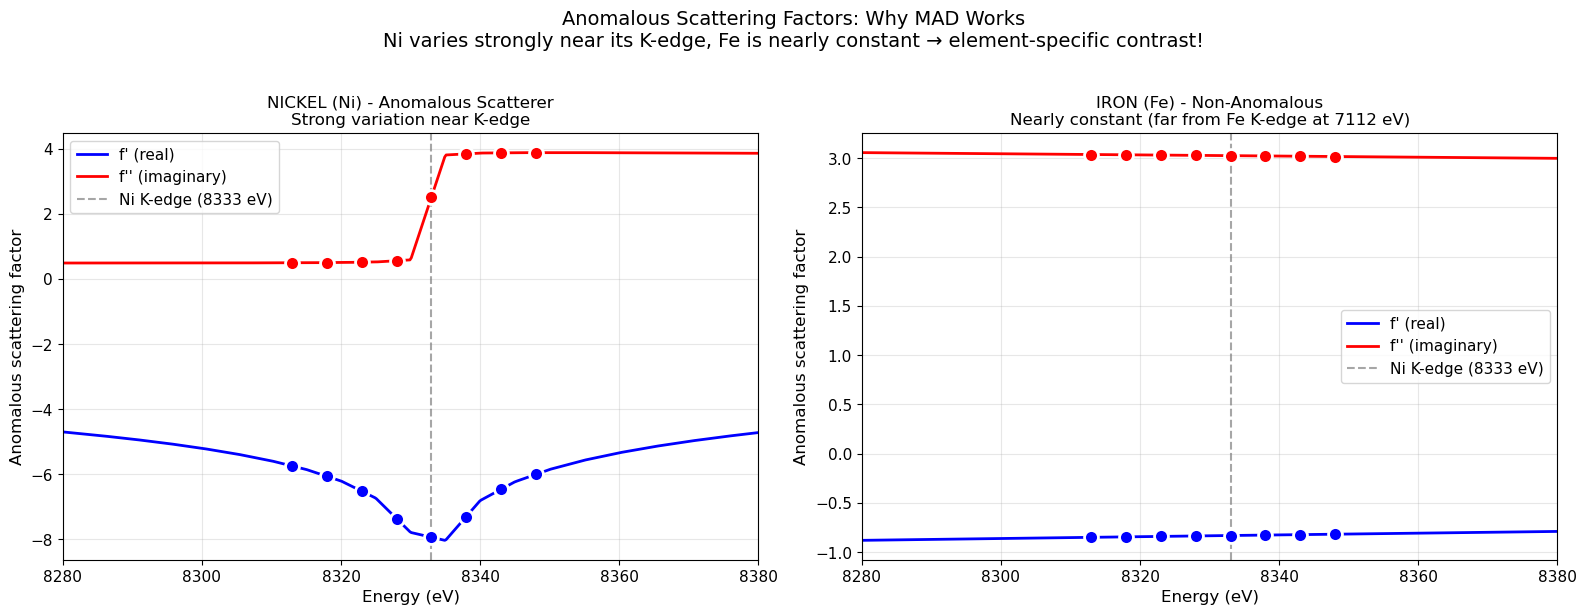


SCATTERING FACTORS AT MEASUREMENT ENERGIES
 Energy (eV) |      Ni f' |     Ni f'' |      Fe f' |     Fe f''
----------------------------------------------------------------------
        8313 |     -5.751 |      0.497 |     -0.849 |      3.037
        8318 |     -6.069 |      0.503 |     -0.845 |      3.034
        8323 |     -6.528 |      0.515 |     -0.840 |      3.031
        8328 |     -7.371 |      0.560 |     -0.836 |      3.028
        8333 |     -7.941 |      2.521 |     -0.831 |      3.025
        8338 |     -7.304 |      3.847 |     -0.827 |      3.022
        8343 |     -6.467 |      3.877 |     -0.822 |      3.019
        8348 |     -6.008 |      3.883 |     -0.818 |      3.017

Key insight: Ni f' varies from -7.9 to -5.8 (delta = 2.2)
             Fe f' varies from -0.8 to -0.8 (delta = 0.0)

This difference allows us to separate Ni and Fe contributions!


In [16]:
# =============================================================================
# LOAD AND VISUALIZE SCATTERING FACTORS
# =============================================================================

# Load scattering factor data (from Henke tables)
# ScatteringFactors auto-detects data directory, or use data_dir='../data' explicitly
sf = ScatteringFactors()

# Compute f'/f'' at our measurement energies
f_prime_Ni = np.array([sf.get_f_prime('Ni', E) for E in ENERGIES])
f_double_prime_Ni = np.array([sf.get_f_double_prime('Ni', E) for E in ENERGIES])
f_prime_Fe = np.array([sf.get_f_prime('Fe', E) for E in ENERGIES])
f_double_prime_Fe = np.array([sf.get_f_double_prime('Fe', E) for E in ENERGIES])

# Also get fine energy grid for smooth curves
E_fine = np.linspace(8280, 8380, 500)
fp_Ni_fine = np.array([sf.get_f_prime('Ni', E) for E in E_fine])
fpp_Ni_fine = np.array([sf.get_f_double_prime('Ni', E) for E in E_fine])
fp_Fe_fine = np.array([sf.get_f_prime('Fe', E) for E in E_fine])
fpp_Fe_fine = np.array([sf.get_f_double_prime('Fe', E) for E in E_fine])

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Ni scattering factors
ax = axes[0]
ax.plot(E_fine, fp_Ni_fine, 'b-', label="f' (real)", linewidth=2)
ax.plot(E_fine, fpp_Ni_fine, 'r-', label="f'' (imaginary)", linewidth=2)
ax.scatter(ENERGIES, f_prime_Ni, c='b', s=100, zorder=5, edgecolors='white', linewidths=2)
ax.scatter(ENERGIES, f_double_prime_Ni, c='r', s=100, zorder=5, edgecolors='white', linewidths=2)
ax.axvline(8333, color='gray', linestyle='--', label='Ni K-edge (8333 eV)', alpha=0.7)
ax.set_xlabel('Energy (eV)', fontsize=12)
ax.set_ylabel('Anomalous scattering factor', fontsize=12)
ax.set_title('NICKEL (Ni) - Anomalous Scatterer\nStrong variation near K-edge', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim(8280, 8380)

# Fe scattering factors (for comparison)
ax = axes[1]
ax.plot(E_fine, fp_Fe_fine, 'b-', label="f' (real)", linewidth=2)
ax.plot(E_fine, fpp_Fe_fine, 'r-', label="f'' (imaginary)", linewidth=2)
ax.scatter(ENERGIES, f_prime_Fe, c='b', s=100, zorder=5, edgecolors='white', linewidths=2)
ax.scatter(ENERGIES, f_double_prime_Fe, c='r', s=100, zorder=5, edgecolors='white', linewidths=2)
ax.axvline(8333, color='gray', linestyle='--', label='Ni K-edge (8333 eV)', alpha=0.7)
ax.set_xlabel('Energy (eV)', fontsize=12)
ax.set_ylabel('Anomalous scattering factor', fontsize=12)
ax.set_title('IRON (Fe) - Non-Anomalous\nNearly constant (far from Fe K-edge at 7112 eV)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim(8280, 8380)

plt.suptitle('Anomalous Scattering Factors: Why MAD Works\n'
             'Ni varies strongly near its K-edge, Fe is nearly constant → element-specific contrast!',
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("SCATTERING FACTORS AT MEASUREMENT ENERGIES")
print("="*70)
ni_fp = "Ni f'"
ni_fpp = "Ni f''"
fe_fp = "Fe f'"
fe_fpp = "Fe f''"
print(f"{'Energy (eV)':>12} | {ni_fp:>10} | {ni_fpp:>10} | {fe_fp:>10} | {fe_fpp:>10}")
print("-"*70)
for i, E in enumerate(ENERGIES):
    print(f"{E:>12} | {f_prime_Ni[i]:>10.3f} | {f_double_prime_Ni[i]:>10.3f} | {f_prime_Fe[i]:>10.3f} | {f_double_prime_Fe[i]:>10.3f}")
print("="*70)
print(f"\nKey insight: Ni f' varies from {f_prime_Ni.min():.1f} to {f_prime_Ni.max():.1f} (delta = {f_prime_Ni.max()-f_prime_Ni.min():.1f})")
print(f"             Fe f' varies from {f_prime_Fe.min():.1f} to {f_prime_Fe.max():.1f} (delta = {f_prime_Fe.max()-f_prime_Fe.min():.1f})")
print(f"\nThis difference allows us to separate Ni and Fe contributions!")

In [17]:
# =============================================================================
# COMPUTE MULTI-ENERGY DIFFRACTION FOR ONE PARTICLE
# =============================================================================
# Let's use the hexagon as our example

example_shape = 'hexagon'
particle_strained = strained_particles[example_shape]

print(f"Computing multi-energy diffraction for {example_shape} particle...")
print(f"  Grid size: {GRID_SIZE}×{GRID_SIZE}")
print(f"  Output size: {GRID_SIZE_OUTPUT}×{GRID_SIZE_OUTPUT}")
print(f"  Energies: {ENERGIES}")
print()

diffractions = compute_diffraction_oversampled_cropped(
    particle=particle_strained,
    energies=ENERGIES,
    pixel_size=PIXEL_SIZE,
    scattering_factors=sf,
    output_size=GRID_SIZE_OUTPUT,
    verbose=True
)

Computing multi-energy diffraction for hexagon particle...
  Grid size: 256×256
  Output size: 128×128
  Energies: [8313, 8318, 8323, 8328, 8333, 8338, 8343, 8348]


  Computing oversampled diffraction:
    FFT grid size: 256 × 256
    Output size (after crop): 128 × 128
    Pixel size: 5.0 Å
    Grid extent: 128.0 nm
    Computed 8 diffraction patterns
    Each pattern cropped from 256×256 to 128×128


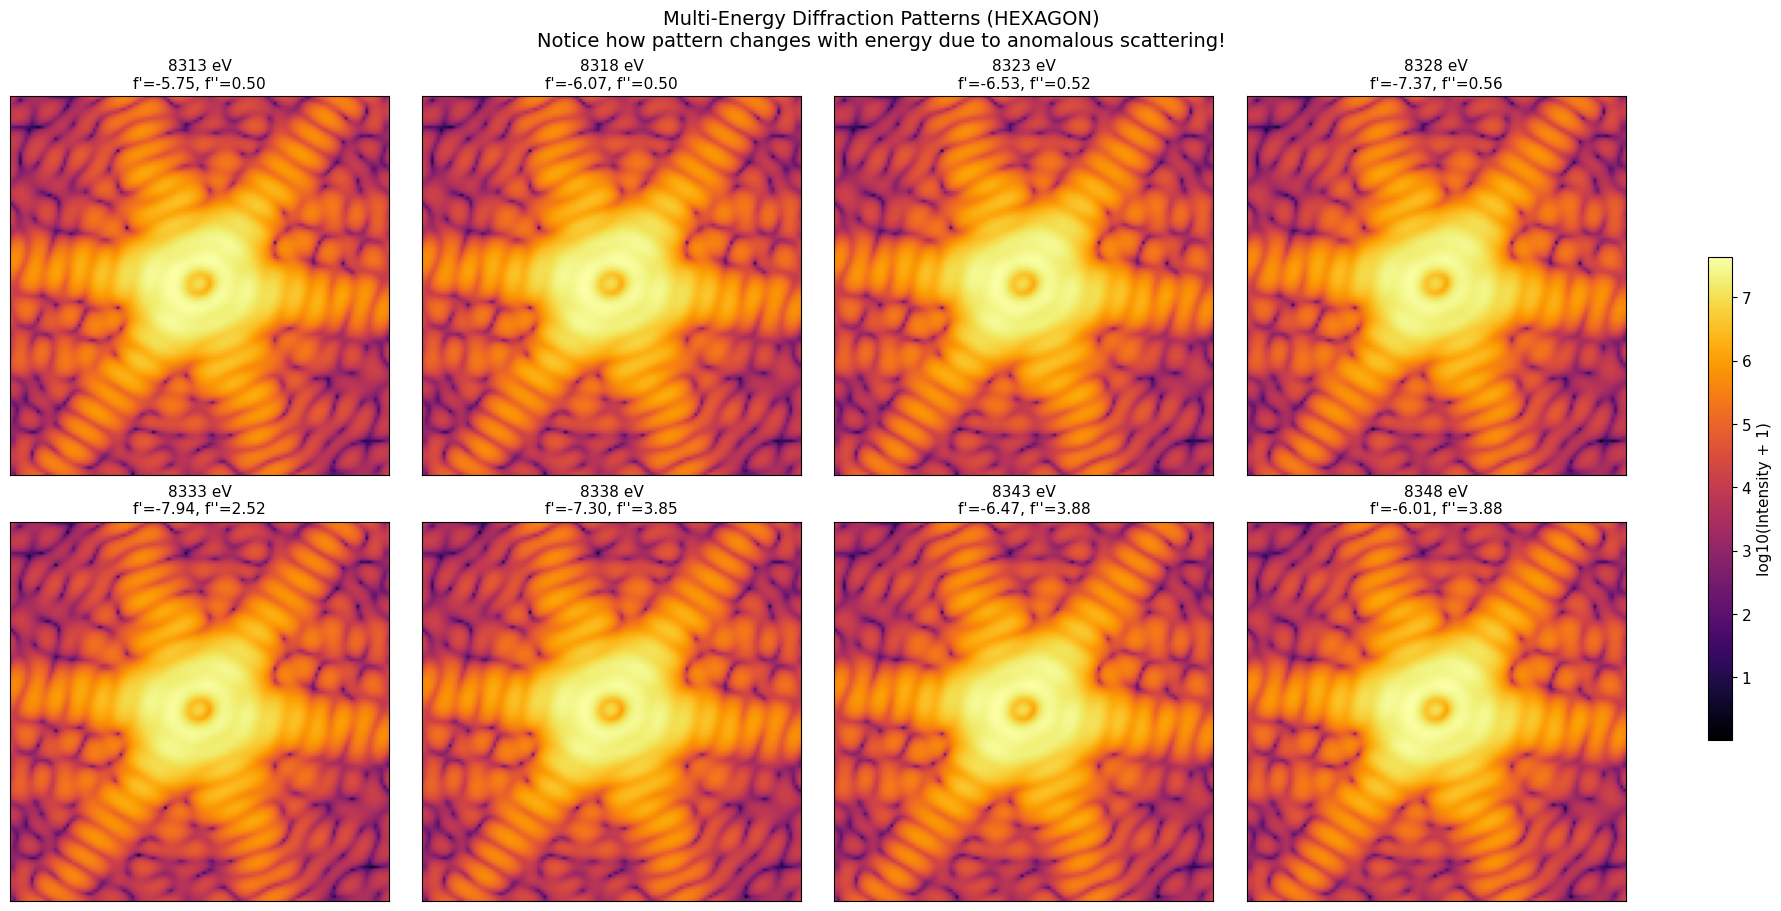


Key observation: The diffraction pattern intensity changes with energy
because the Ni scattering factor changes near its K-edge.
This energy-dependent variation is what allows MAD analysis!


In [18]:
# =============================================================================
# VISUALIZE MULTI-ENERGY DIFFRACTION PATTERNS
# =============================================================================

fig, axes = plt.subplots(2, 4, figsize=(18, 9), constrained_layout=True)

# Compute intensity for all energies
intensities = {E: np.abs(diffractions[E])**2 for E in ENERGIES}

# Common colorscale
all_log_I = [np.log10(I + 1) for I in intensities.values()]
vmin = min(x.min() for x in all_log_I)
vmax = max(x.max() for x in all_log_I)

for i, E in enumerate(ENERGIES):
    row, col = i // 4, i % 4
    I_log = np.log10(intensities[E] + 1)
    
    im = axes[row, col].imshow(I_log, cmap='inferno', origin='lower',
                                vmin=vmin, vmax=vmax)
    
    # Add f'/f'' annotation
    fp = f_prime_Ni[i]
    fpp = f_double_prime_Ni[i]
    axes[row, col].set_title(f'{E} eV\nf\'={fp:.2f}, f\'\'={fpp:.2f}', fontsize=11)
    axes[row, col].set_xticks([])
    axes[row, col].set_yticks([])

# Add colorbar to the right side
fig.colorbar(im, ax=axes, shrink=0.6, label='log10(Intensity + 1)')

plt.suptitle(f'Multi-Energy Diffraction Patterns ({example_shape.upper()})\n'
             'Notice how pattern changes with energy due to anomalous scattering!',
             fontsize=14)
plt.show()

print("\nKey observation: The diffraction pattern intensity changes with energy")
print("because the Ni scattering factor changes near its K-edge.")
print("This energy-dependent variation is what allows MAD analysis!")

---

# Part 4: Ground Truth Labels

## What the CNN Learns to Predict

For each pixel in the diffraction pattern, the CNN predicts **4 values**:

| Output | Symbol | Description | Range |
|--------|--------|-------------|-------|
| 0 | |F_T| | Total structure factor magnitude | [0, ∞) stored as log1p |
| 1 | |F_A| | Anomalous structure factor magnitude | [0, ∞) stored as log1p |
| 2 | sin(Δφ) | Sine of phase difference | [-1, 1] |
| 3 | cos(Δφ) | Cosine of phase difference | [-1, 1] |

## How Ground Truth is Computed

We compute the ground truth labels directly from the particle definition:

1. **F_T** (Total): FFT of the weighted sum of all atoms
   $$F_T = f_{Ni}(Q) \cdot FFT[\rho_{Ni}] + f_{Fe}(Q) \cdot FFT[\rho_{Fe}]$$

2. **F_A** (Anomalous): FFT of only the anomalous atoms (Ni), weighted by f₀
   $$F_A = f_0^{Ni}(Q) \cdot FFT[\rho_{Ni}]$$

3. **Δφ** (Phase difference): 
   $$\Delta\phi = \phi_T - \phi_A = \arg(F_T) - \arg(F_A)$$

We store sin(Δφ) and cos(Δφ) instead of Δφ directly because:
- Avoids phase wrapping issues at ±π
- The CNN can naturally predict bounded values [-1, 1]
- We recover Δφ = atan2(sin, cos) at inference

In [19]:
# =============================================================================
# COMPUTE GROUND TRUTH LABELS
# =============================================================================

print("Computing ground truth labels...")
print("="*70)

labels = compute_ground_truth_labels(
    particle=particle_strained,
    pixel_size=PIXEL_SIZE,
    output_size=GRID_SIZE_OUTPUT,
    verbose=True
)

print("\n" + "="*70)
print("GROUND TRUTH LABELS COMPUTED")
print("="*70)
print(f"\nAvailable labels:")
for key, arr in labels.items():
    print(f"  {key:20s}: shape={arr.shape}, range=[{arr.min():.2e}, {arr.max():.2e}]")

Computing ground truth labels...

  Computing ground truth labels (Thomson-weighted)...
    f₀_Ni(Q=0) = 27.99 (atomic number ~28)
    f₀_Fe(Q=0) = 25.99 (atomic number ~26)
    Q_max = 0.63 Å⁻¹
    |F_T| range: [1.08e+00, 7.99e+03]
    |F_A| range: [2.90e+00, 7.32e+03]
    |F_A|/|F_T| at max: 91.63%
    Δφ range: [-3.137, 3.135] rad
    Δφ range: [-179.7°, 179.6°]
    |F_N| (direct) range: [6.15e-01, 1.46e+03]
    |F_N| (derived) range: [6.15e-01, 1.46e+03]
    |F_N| derivation error (max relative): 1.75e-15

GROUND TRUTH LABELS COMPUTED

Available labels:
  F_T_mag             : shape=(128, 128), range=[1.08e+00, 7.99e+03]
  F_A_mag             : shape=(128, 128), range=[2.90e+00, 7.32e+03]
  delta_phi           : shape=(128, 128), range=[-3.14e+00, 3.13e+00]
  cos_delta_phi       : shape=(128, 128), range=[-1.00e+00, 1.00e+00]
  sin_delta_phi       : shape=(128, 128), range=[-1.00e+00, 1.00e+00]
  F_N_mag             : shape=(128, 128), range=[6.15e-01, 1.46e+03]
  F_N_mag_derived  

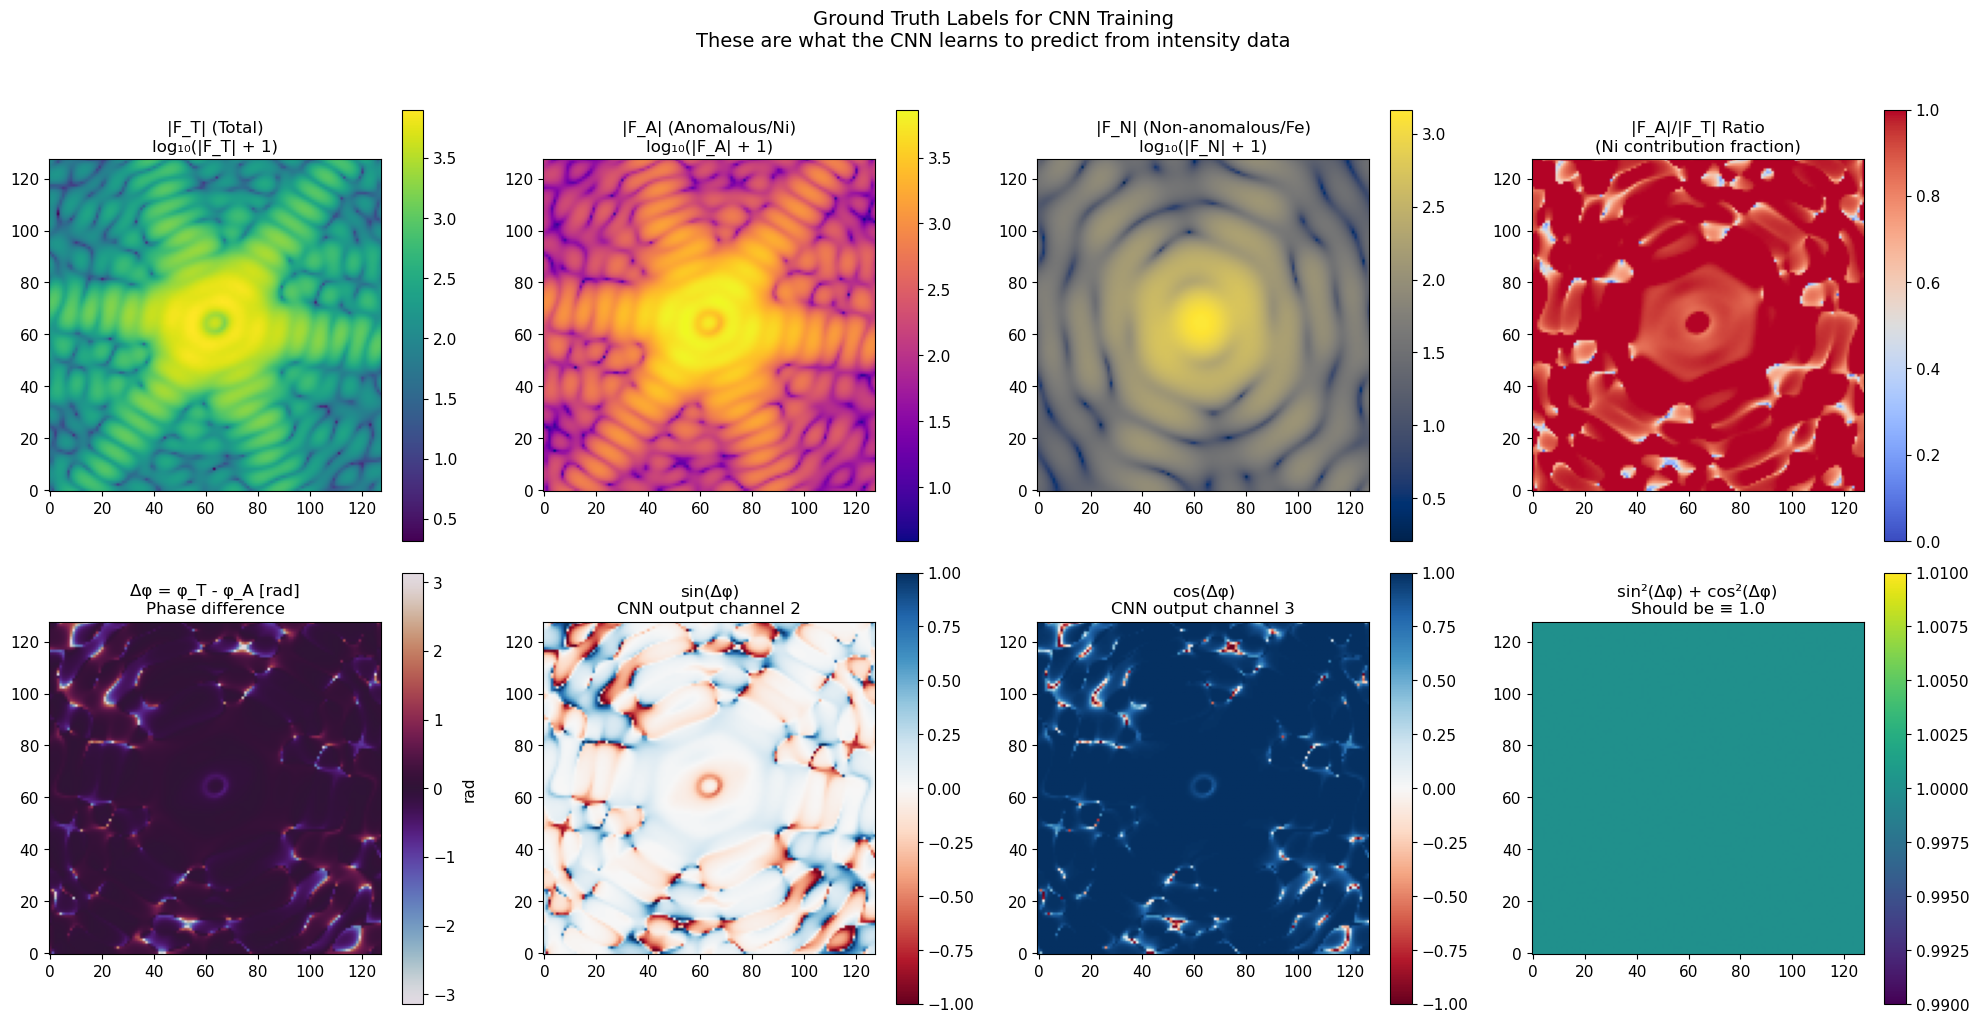

In [20]:
# =============================================================================
# VISUALIZE ALL GROUND TRUTH LABELS
# =============================================================================

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Row 1: Magnitudes (log scale for visibility)
# |F_T|
im = axes[0, 0].imshow(np.log10(labels['F_T_mag'] + 1), cmap='viridis', origin='lower')
axes[0, 0].set_title('|F_T| (Total)\nlog₁₀(|F_T| + 1)', fontsize=12)
plt.colorbar(im, ax=axes[0, 0])

# |F_A|
im = axes[0, 1].imshow(np.log10(labels['F_A_mag'] + 1), cmap='plasma', origin='lower')
axes[0, 1].set_title('|F_A| (Anomalous/Ni)\nlog₁₀(|F_A| + 1)', fontsize=12)
plt.colorbar(im, ax=axes[0, 1])

# |F_N| (non-anomalous = Fe)
im = axes[0, 2].imshow(np.log10(labels['F_N_mag'] + 1), cmap='cividis', origin='lower')
axes[0, 2].set_title('|F_N| (Non-anomalous/Fe)\nlog₁₀(|F_N| + 1)', fontsize=12)
plt.colorbar(im, ax=axes[0, 2])

# Ratio |F_A|/|F_T|
ratio = labels['F_A_mag'] / (labels['F_T_mag'] + 1e-10)
im = axes[0, 3].imshow(ratio, cmap='coolwarm', origin='lower', vmin=0, vmax=1)
axes[0, 3].set_title('|F_A|/|F_T| Ratio\n(Ni contribution fraction)', fontsize=12)
plt.colorbar(im, ax=axes[0, 3])

# Row 2: Phase information
# Δφ
im = axes[1, 0].imshow(labels['delta_phi'], cmap='twilight', origin='lower', 
                        vmin=-np.pi, vmax=np.pi)
axes[1, 0].set_title('Δφ = φ_T - φ_A [rad]\nPhase difference', fontsize=12)
plt.colorbar(im, ax=axes[1, 0], label='rad')

# sin(Δφ)
im = axes[1, 1].imshow(labels['sin_delta_phi'], cmap='RdBu', origin='lower', vmin=-1, vmax=1)
axes[1, 1].set_title('sin(Δφ)\nCNN output channel 2', fontsize=12)
plt.colorbar(im, ax=axes[1, 1])

# cos(Δφ)
im = axes[1, 2].imshow(labels['cos_delta_phi'], cmap='RdBu', origin='lower', vmin=-1, vmax=1)
axes[1, 2].set_title('cos(Δφ)\nCNN output channel 3', fontsize=12)
plt.colorbar(im, ax=axes[1, 2])

# Verify sin²+cos² = 1
sin2_cos2 = labels['sin_delta_phi']**2 + labels['cos_delta_phi']**2
im = axes[1, 3].imshow(sin2_cos2, cmap='viridis', origin='lower', vmin=0.99, vmax=1.01)
axes[1, 3].set_title('sin²(Δφ) + cos²(Δφ)\nShould be ≡ 1.0', fontsize=12)
plt.colorbar(im, ax=axes[1, 3])

plt.suptitle('Ground Truth Labels for CNN Training\n'
             'These are what the CNN learns to predict from intensity data',
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---

# Part 5: Deriving F_N (Isolating Core vs Shell)

## The Key Result: Separating Fe from Ni

From the MAD parameters, we can compute **F_N** (the non-anomalous structure factor), which represents scattering from **only the Fe atoms** (the core!):

$$|F_N|^2 = |F_T|^2 + |F_A|^2 - 2|F_T||F_A|\cos(\Delta\phi)$$

This is the **law of cosines** for complex number subtraction:
$$F_N = F_T - F_A$$

### Why This Matters

- **F_T** contains contributions from ALL atoms (Fe + Ni)
- **F_A** contains contributions from ANOMALOUS atoms only (Ni)
- **F_N = F_T - F_A** contains contributions from NON-ANOMALOUS atoms only (Fe)

This allows us to **image the core and shell separately** from a single dataset!

In [21]:
# =============================================================================
# DEFINE F_N COMPUTATION (LOCAL VERSION - NO TORCH DEPENDENCY)
# =============================================================================

def compute_F_N(F_T, F_A, delta_phi):
    """
    Compute |F_N| (non-anomalous structure factor magnitude) from MAD parameters.
    
    This uses the law of cosines for complex subtraction:
        |F_N|² = |F_T|² + |F_A|² - 2|F_T||F_A|cos(Δφ)
    
    Where F_N = F_T - F_A (complex subtraction).
    
    Parameters
    ----------
    F_T : np.ndarray
        Total structure factor magnitude |F_T|
    F_A : np.ndarray
        Anomalous structure factor magnitude |F_A|
    delta_phi : np.ndarray
        Phase difference Δφ = φ_T - φ_A in radians
        
    Returns
    -------
    F_N : np.ndarray
        Non-anomalous structure factor magnitude |F_N|
    """
    # Law of cosines
    F_N_squared = F_T**2 + F_A**2 - 2 * F_T * F_A * np.cos(delta_phi)
    
    # Handle numerical issues (tiny negative values from floating point)
    F_N_squared = np.maximum(F_N_squared, 0)
    
    return np.sqrt(F_N_squared)

print("F_N computation function defined (no PyTorch required!)")

F_N computation function defined (no PyTorch required!)


In [22]:
# =============================================================================
# DEMONSTRATE F_N DERIVATION
# =============================================================================

# Get ground truth values
F_T = labels['F_T_mag']
F_A = labels['F_A_mag']
delta_phi = labels['delta_phi']

# Compute F_N using our formula
F_N_derived = compute_F_N(F_T, F_A, delta_phi)

# Compare with direct computation (should match!)
F_N_direct = labels['F_N_mag']

# Check error
rel_error = np.abs(F_N_derived - F_N_direct) / (F_N_direct + 1e-10)
max_rel_error = rel_error.max()

print("="*70)
print("F_N DERIVATION VERIFICATION")
print("="*70)
print(f"Direct computation: |F_N| range = [{F_N_direct.min():.2f}, {F_N_direct.max():.2f}]")
print(f"Derived from F_T, F_A, Δφ: |F_N| range = [{F_N_derived.min():.2f}, {F_N_derived.max():.2f}]")
print(f"Maximum relative error: {max_rel_error:.2e}")
print(f"\n✓ The derivation formula works perfectly!")

F_N DERIVATION VERIFICATION
Direct computation: |F_N| range = [0.62, 1461.92]
Derived from F_T, F_A, Δφ: |F_N| range = [0.62, 1461.92]
Maximum relative error: 1.14e-10

✓ The derivation formula works perfectly!


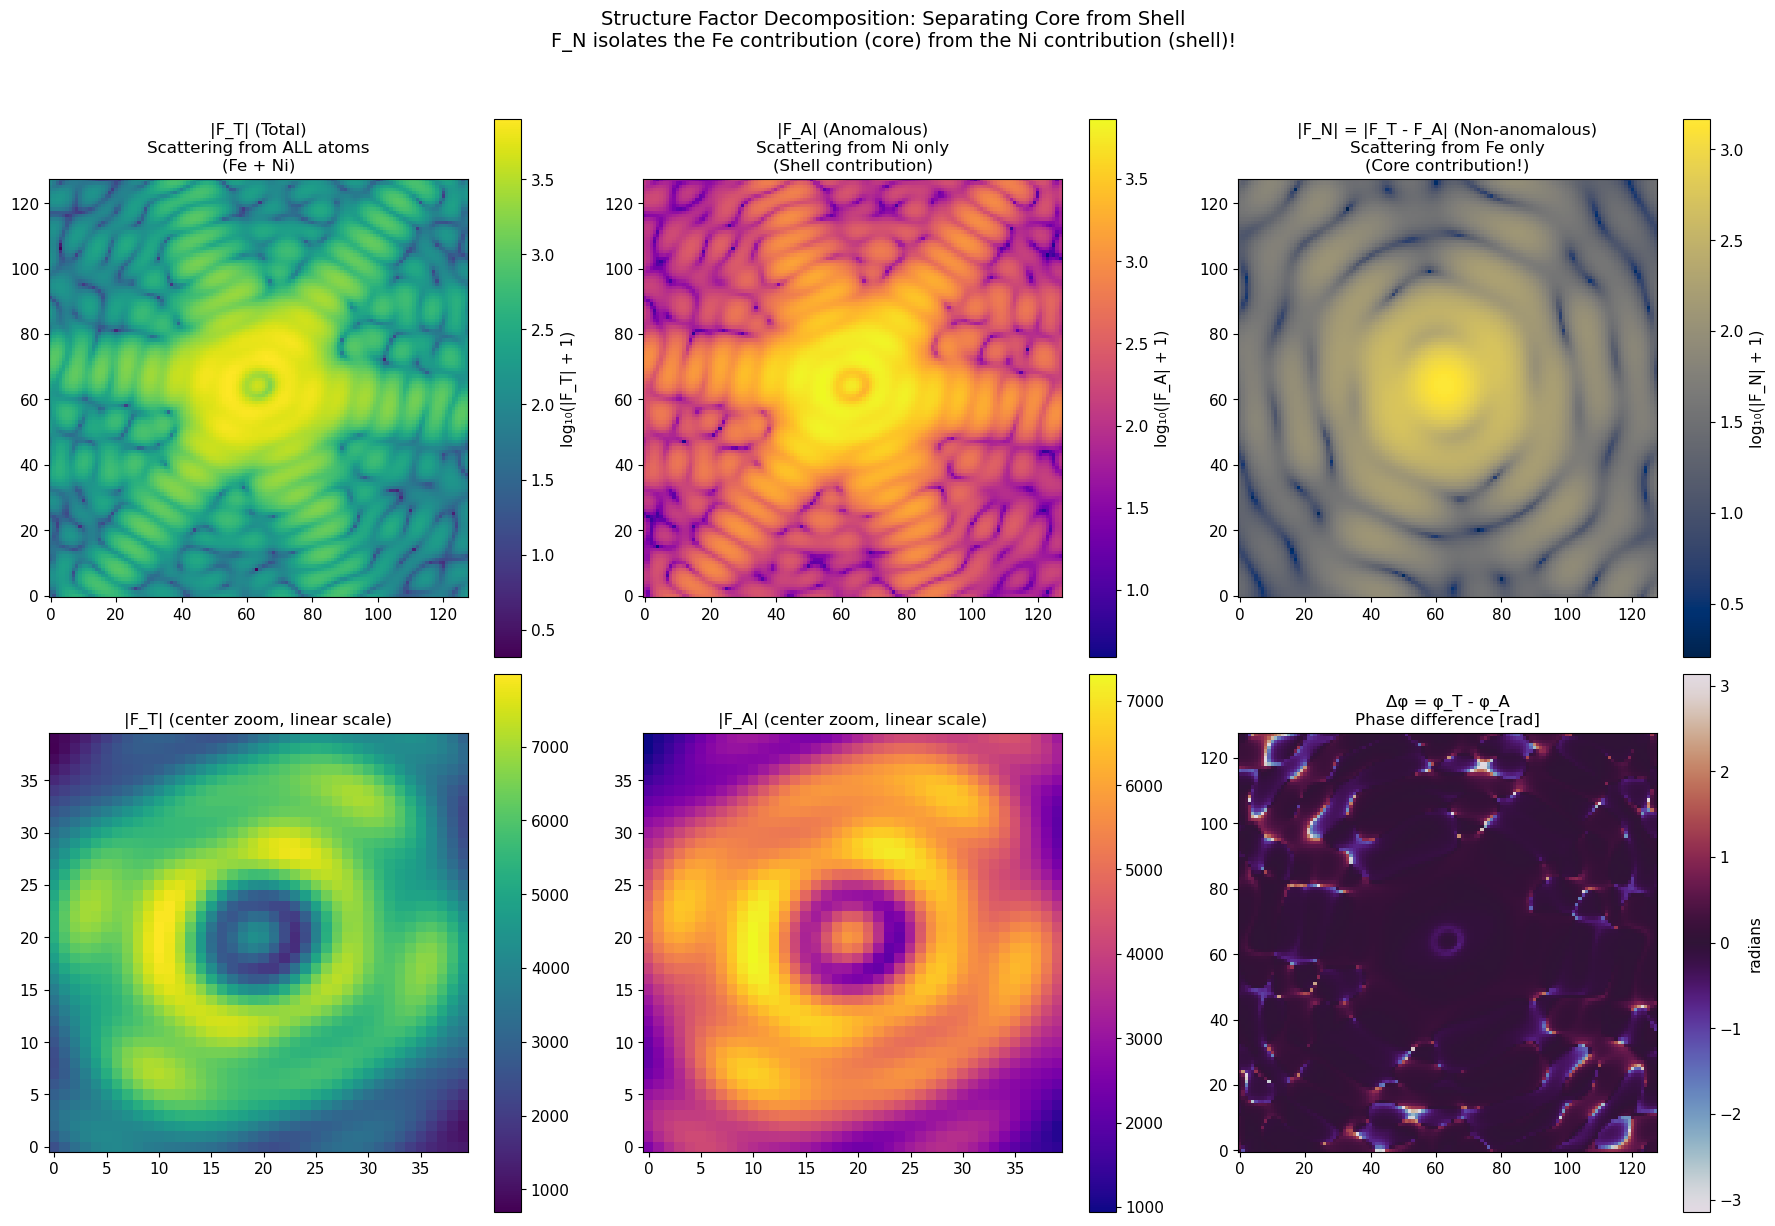


PHYSICAL INTERPRETATION

The MAD analysis allows us to separate scattering contributions:

  F_T = Total scattering from all atoms in the particle
      = F_Ni + F_Fe (complex sum)
      
  F_A = Scattering from anomalous (Ni) atoms only
      = F_Ni
      
  F_N = F_T - F_A = Scattering from non-anomalous (Fe) atoms only
      = F_Fe

For our core-shell particle:
  - F_A (Ni) shows the SHELL contribution
  - F_N (Fe) shows the CORE contribution
  
This separation is achieved by exploiting the energy-dependent variation
of the Ni scattering factor near its K-edge!



In [23]:
# =============================================================================
# VISUALIZE STRUCTURE FACTOR DECOMPOSITION
# =============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: Structure factor magnitudes
im = axes[0, 0].imshow(np.log10(F_T + 1), cmap='viridis', origin='lower')
axes[0, 0].set_title('|F_T| (Total)\nScattering from ALL atoms\n(Fe + Ni)', fontsize=12)
plt.colorbar(im, ax=axes[0, 0], label='log₁₀(|F_T| + 1)')

im = axes[0, 1].imshow(np.log10(F_A + 1), cmap='plasma', origin='lower')
axes[0, 1].set_title('|F_A| (Anomalous)\nScattering from Ni only\n(Shell contribution)', fontsize=12)
plt.colorbar(im, ax=axes[0, 1], label='log₁₀(|F_A| + 1)')

im = axes[0, 2].imshow(np.log10(F_N_derived + 1), cmap='cividis', origin='lower')
axes[0, 2].set_title('|F_N| = |F_T - F_A| (Non-anomalous)\nScattering from Fe only\n(Core contribution!)', fontsize=12)
plt.colorbar(im, ax=axes[0, 2], label='log₁₀(|F_N| + 1)')

# Row 2: Linear scale comparison + phase
# Central region zoom
c = GRID_SIZE_OUTPUT // 2
w = 20  # half-width of zoom region

im = axes[1, 0].imshow(F_T[c-w:c+w, c-w:c+w], cmap='viridis', origin='lower')
axes[1, 0].set_title('|F_T| (center zoom, linear scale)', fontsize=12)
plt.colorbar(im, ax=axes[1, 0])

im = axes[1, 1].imshow(F_A[c-w:c+w, c-w:c+w], cmap='plasma', origin='lower')
axes[1, 1].set_title('|F_A| (center zoom, linear scale)', fontsize=12)
plt.colorbar(im, ax=axes[1, 1])

im = axes[1, 2].imshow(delta_phi, cmap='twilight', origin='lower', vmin=-np.pi, vmax=np.pi)
axes[1, 2].set_title('Δφ = φ_T - φ_A\nPhase difference [rad]', fontsize=12)
plt.colorbar(im, ax=axes[1, 2], label='radians')

plt.suptitle('Structure Factor Decomposition: Separating Core from Shell\n'
             'F_N isolates the Fe contribution (core) from the Ni contribution (shell)!',
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("PHYSICAL INTERPRETATION")
print("="*70)
print(f"""
The MAD analysis allows us to separate scattering contributions:

  F_T = Total scattering from all atoms in the particle
      = F_Ni + F_Fe (complex sum)
      
  F_A = Scattering from anomalous (Ni) atoms only
      = F_Ni
      
  F_N = F_T - F_A = Scattering from non-anomalous (Fe) atoms only
      = F_Fe

For our core-shell particle:
  - F_A (Ni) shows the SHELL contribution
  - F_N (Fe) shows the CORE contribution
  
This separation is achieved by exploiting the energy-dependent variation
of the Ni scattering factor near its K-edge!
""")

---

# Part 6: Training Data Format

## Data File Structure

Each training particle is saved as a `.npz` file with the following arrays:

```python
particle_XXXX.npz:
    X: (n_patches, 16, 16, 8)     # Intensity patches at 8 energies
    Y: (n_patches, 16, 16, 4)     # Labels: |F_T|, |F_A|, sin(Δφ), cos(Δφ)
    f_prime: (8,)                  # f'(E) values for Ni
    f_double_prime: (8,)           # f''(E) values for Ni
    energies: (8,)                 # Energy values in eV
```

## Important: Log Scale for Magnitudes

The magnitude labels (|F_T|, |F_A|) have a huge dynamic range (0 to 80,000+). To help the CNN learn, we store them in **log scale**:

- **Training**: Store `log1p(|F|)` = `log(1 + |F|)`
- **Inference**: Recover with `expm1(y)` = `exp(y) - 1`

The `log1p`/`expm1` functions handle the case where |F| ≈ 0 better than plain `log`/`exp`.

In [24]:
# =============================================================================
# CREATE TRAINING DATA EXAMPLE
# =============================================================================

# Build intensity cube from diffraction patterns
intensity_list = [np.abs(diffractions[E])**2 for E in ENERGIES]
intensity_cube = np.stack(intensity_list, axis=-1)  # (128, 128, 8)

print(f"Intensity cube shape: {intensity_cube.shape}")
print(f"  = (height, width, n_energies)")

# Extract patches
def extract_patches(cube, patch_size=16):
    """Extract non-overlapping patches from a (H, W, C) array."""
    ny, nx, nc = cube.shape
    n_patches_y = ny // patch_size
    n_patches_x = nx // patch_size
    patches = np.zeros((n_patches_y * n_patches_x, patch_size, patch_size, nc))
    
    idx = 0
    for i in range(n_patches_y):
        for j in range(n_patches_x):
            y_start = i * patch_size
            x_start = j * patch_size
            patches[idx] = cube[y_start:y_start+patch_size, x_start:x_start+patch_size, :]
            idx += 1
    
    return patches

X = extract_patches(intensity_cube, PATCH_SIZE)
print(f"\nX (intensity patches): {X.shape}")
print(f"  = (n_patches, patch_h, patch_w, n_energies)")
print(f"  = {X.shape[0]} patches of {PATCH_SIZE}×{PATCH_SIZE} pixels at {len(ENERGIES)} energies")

Intensity cube shape: (128, 128, 8)
  = (height, width, n_energies)

X (intensity patches): (64, 16, 16, 8)
  = (n_patches, patch_h, patch_w, n_energies)
  = 64 patches of 16×16 pixels at 8 energies


In [25]:
# =============================================================================
# EXTRACT LABEL PATCHES
# =============================================================================

label_patches = extract_label_patches(
    labels=labels,
    patch_size=PATCH_SIZE,
    label_keys=['F_T_mag', 'F_A_mag', 'sin_delta_phi', 'cos_delta_phi']
)

# Reshape to (n_patches, H, W, 4)
Y = label_patches.reshape(-1, PATCH_SIZE, PATCH_SIZE, 4)

print(f"Y (label patches): {Y.shape}")
print(f"  = (n_patches, patch_h, patch_w, n_channels)")
print(f"")
print(f"Label channels:")
print(f"  Channel 0: |F_T| - range [{Y[...,0].min():.1f}, {Y[...,0].max():.1f}]")
print(f"  Channel 1: |F_A| - range [{Y[...,1].min():.1f}, {Y[...,1].max():.1f}]")
print(f"  Channel 2: sin(Δφ) - range [{Y[...,2].min():.3f}, {Y[...,2].max():.3f}]")
print(f"  Channel 3: cos(Δφ) - range [{Y[...,3].min():.3f}, {Y[...,3].max():.3f}]")

Y (label patches): (64, 16, 16, 4)
  = (n_patches, patch_h, patch_w, n_channels)

Label channels:
  Channel 0: |F_T| - range [1.1, 7989.7]
  Channel 1: |F_A| - range [2.9, 7321.1]
  Channel 2: sin(Δφ) - range [-1.000, 1.000]
  Channel 3: cos(Δφ) - range [-1.000, 1.000]


In [26]:
# =============================================================================
# CONVERT TO LOG SCALE AND SAVE
# =============================================================================

# Convert magnitudes to log scale for training
Y_log = Y.copy()
Y_log[..., 0] = np.log1p(Y[..., 0])  # |F_T|
Y_log[..., 1] = np.log1p(Y[..., 1])  # |F_A|
# sin/cos already in [-1, 1], no conversion needed

print("After log scale conversion:")
print(f"  Channel 0: log1p(|F_T|) - range [{Y_log[...,0].min():.2f}, {Y_log[...,0].max():.2f}]")
print(f"  Channel 1: log1p(|F_A|) - range [{Y_log[...,1].min():.2f}, {Y_log[...,1].max():.2f}]")
print(f"  Channel 2: sin(Δφ) - range [{Y_log[...,2].min():.3f}, {Y_log[...,2].max():.3f}]")
print(f"  Channel 3: cos(Δφ) - range [{Y_log[...,3].min():.3f}, {Y_log[...,3].max():.3f}]")

# Save example file
output_path = Path('demo_particle.npz')
np.savez_compressed(
    output_path,
    X=X.astype(np.float32),
    Y=Y_log.astype(np.float32),
    f_prime=f_prime_Ni.astype(np.float32),
    f_double_prime=f_double_prime_Ni.astype(np.float32),
    energies=np.array(ENERGIES, dtype=np.float32)
)

print(f"\nSaved demo particle to: {output_path}")
print(f"File size: {output_path.stat().st_size / 1024:.1f} KB")

After log scale conversion:
  Channel 0: log1p(|F_T|) - range [0.73, 8.99]
  Channel 1: log1p(|F_A|) - range [1.36, 8.90]
  Channel 2: sin(Δφ) - range [-1.000, 1.000]
  Channel 3: cos(Δφ) - range [-1.000, 1.000]

Saved demo particle to: demo_particle.npz
File size: 702.0 KB


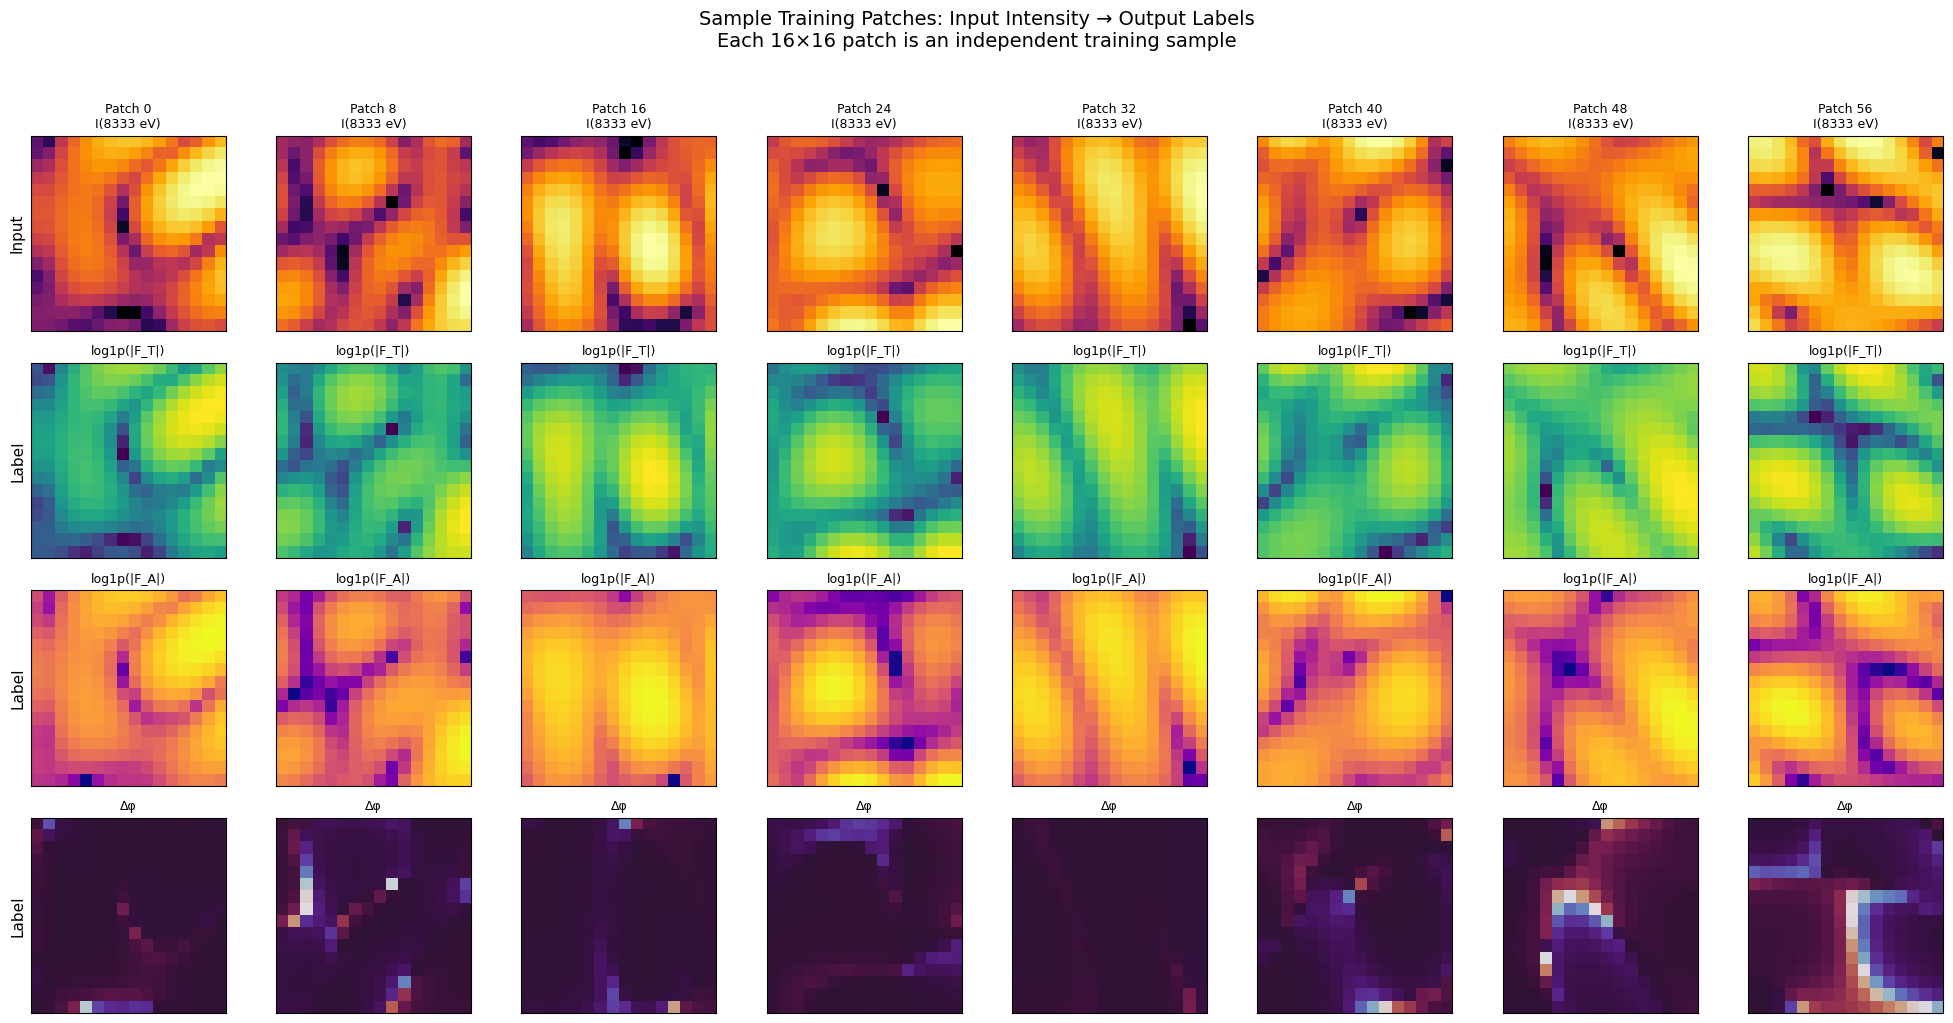

In [27]:
# =============================================================================
# VISUALIZE SOME PATCHES
# =============================================================================

fig, axes = plt.subplots(4, 8, figsize=(20, 10))

# Show 8 patches (columns) with 4 views each (rows)
patch_indices = [0, 8, 16, 24, 32, 40, 48, 56]  # Spread across the image

for col, patch_idx in enumerate(patch_indices):
    # Row 0: Intensity at E=8333 eV (center energy)
    im = axes[0, col].imshow(np.log10(X[patch_idx, :, :, 4] + 1), cmap='inferno')
    axes[0, col].set_title(f'Patch {patch_idx}\nI(8333 eV)', fontsize=9)
    axes[0, col].set_xticks([])
    axes[0, col].set_yticks([])
    
    # Row 1: |F_T| label
    im = axes[1, col].imshow(Y_log[patch_idx, :, :, 0], cmap='viridis')
    axes[1, col].set_title(f'log1p(|F_T|)', fontsize=9)
    axes[1, col].set_xticks([])
    axes[1, col].set_yticks([])
    
    # Row 2: |F_A| label
    im = axes[2, col].imshow(Y_log[patch_idx, :, :, 1], cmap='plasma')
    axes[2, col].set_title(f'log1p(|F_A|)', fontsize=9)
    axes[2, col].set_xticks([])
    axes[2, col].set_yticks([])
    
    # Row 3: Δφ (recovered from sin/cos)
    delta_phi_patch = np.arctan2(Y[patch_idx, :, :, 2], Y[patch_idx, :, :, 3])
    im = axes[3, col].imshow(delta_phi_patch, cmap='twilight', vmin=-np.pi, vmax=np.pi)
    axes[3, col].set_title(f'Δφ', fontsize=9)
    axes[3, col].set_xticks([])
    axes[3, col].set_yticks([])

# Row labels
axes[0, 0].set_ylabel('Input', fontsize=11)
axes[1, 0].set_ylabel('Label', fontsize=11)
axes[2, 0].set_ylabel('Label', fontsize=11)
axes[3, 0].set_ylabel('Label', fontsize=11)

plt.suptitle('Sample Training Patches: Input Intensity → Output Labels\n'
             'Each 16×16 patch is an independent training sample',
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---

# Summary

## What We Covered

1. **Particle Types**: Circle, hexagon, polygon, centrosymmetric polygon - all with Fe core and Ni shell

2. **Strain Field Layers**:
   - Interface strain (core-shell lattice mismatch)
   - Surface relaxation (exponential decay from surface)
   - Corner enhancement (geometric strain concentration)
   - Random strain (defects and disorder)

3. **Multi-Energy Diffraction**: How patterns change with energy due to anomalous scattering

4. **Ground Truth Labels**: |F_T|, |F_A|, sin(Δφ), cos(Δφ) computed directly from particle structure

5. **F_N Derivation**: How to isolate core (Fe) from shell (Ni) contributions

6. **Training Data Format**: Patches and labels ready for CNN training

## Key Equations

**MAD Equation:**
$$I(Q,E) = |F_T|^2 + (f'^2 + f''^2)\frac{|F_A|^2}{f_0^2} + 2\frac{|F_T||F_A|}{f_0}[f'\cos(\Delta\phi) + f''\sin(\Delta\phi)]$$

**F_N Derivation:**
$$|F_N|^2 = |F_T|^2 + |F_A|^2 - 2|F_T||F_A|\cos(\Delta\phi)$$

**Phase from Displacement:**
$$\phi(\mathbf{r}) = \mathbf{Q}_{Bragg} \cdot \mathbf{u}(\mathbf{r})$$

## Files

| File | Purpose |
|------|--------|
| `core_shell.py` | Physics engine (particles, diffraction, ground truth) |
| `generate_training_data.py` | Batch training data generation |
| `train_cnn.py` | CNN training pipeline |
| `run_inference.py` | 2D inference and export |
| `run_inference_3d.py` | 3D inference (slice-by-slice) |

In [28]:
# Cleanup
if output_path.exists():
    output_path.unlink()
    print(f"Cleaned up: {output_path}")

print("\n" + "="*70)
print("DEMO COMPLETE!")
print("="*70)

Cleaned up: demo_particle.npz

DEMO COMPLETE!
